In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

v003.ib.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/notebooks


In [2]:
import sys, os, pathlib
import numpy as np
import xarray as xr
import torch
import matplotlib.pyplot as plt
import seaborn as sns

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn

torch.cuda.is_available()

Using backend: pytorch



True

In [3]:
%autoreload
bioqic = mre_pinn.data.BIOQICFEMBox('../data/BIOQIC/downloads')
bioqic.download()
bioqic.load_mat()
bioqic.preprocess()
dataset = bioqic.to_dataset()
dataset.save_xarrays('../data/BIOQIC/fem_box')

Loading ../data/BIOQIC/downloads/four_target_phantom.mat
    __header__: <class 'bytes'>
    __version__: <class 'str'>
    __globals__: <class 'list'>
    u_ft: <class 'numpy.ndarray'> (100, 80, 10, 3, 6) complex128
<xarray.Dataset>
Dimensions:    (frequency: 6, x: 80, y: 100, z: 10, component: 3)
Coordinates:
  * frequency  (frequency) int64 50 60 70 80 90 100
  * x          (x) float64 0.0 0.001 0.002 0.003 ... 0.076 0.077 0.078 0.079
  * y          (y) float64 0.0 0.001 0.002 0.003 ... 0.096 0.097 0.098 0.099
  * z          (z) float64 0.0 0.001 0.002 0.003 ... 0.006 0.007 0.008 0.009
  * component  (component) <U1 'y' 'x' 'z'
Data variables:
    wave       (frequency, x, y, z, component) complex128 (0.0018039287661982...
Segmenting spatial regions
Creating ground truth elastogram
Writing ../data/BIOQIC/fem_box/50/wave.nc
Writing ../data/BIOQIC/fem_box/50/mre.nc
Writing ../data/BIOQIC/fem_box/50/mre_mask.nc
Writing ../data/BIOQIC/fem_box/60/wave.nc
Writing ../data/BIOQIC/fem_box/60

In [4]:
example = mre_pinn.data.MREExample.load_xarrays('../data/BIOQIC/fem_box', 60)
example.metadata

Loading ../data/BIOQIC/fem_box/60/wave.nc
Loading ../data/BIOQIC/fem_box/60/mre.nc
Loading ../data/BIOQIC/fem_box/60/mre_mask.nc


size  spacing  origin  limit  center  extent
variable dimension                                              
wave     x            80    0.001     0.0  0.079  0.0395    0.08
         y           100    0.001     0.0  0.099  0.0495    0.10
         z            10    0.001     0.0  0.009  0.0045    0.01
mre      x            80    0.001     0.0  0.079  0.0395    0.08
         y           100    0.001     0.0  0.099  0.0495    0.10
         z            10    0.001     0.0  0.009  0.0045    0.01
mre_mask x            80    0.001     0.0  0.079  0.0395    0.08
         y           100    0.001     0.0  0.099  0.0495    0.10
         z            10    0.001     0.0  0.009  0.0045    0.01

In [5]:
example.describe()

dtype    count                     mean          std  \
variable component                                                              
wave     y          complex128  80000.0  -0.00000100-0.00001000j     0.000724   
         x          complex128  80000.0   0.00022200-0.00020700j     0.000742   
         z          complex128  80000.0   0.00092400+0.00005900j     0.012493   
mre      scalar     complex128  80000.0  3382.375000+376.991118j  1590.727619   
mre_mask scalar          int64  80000.0   1.07650000+0.00000000j     0.362143   

                                        min                      25%  \
variable component                                                     
wave     y          -0.00198900-0.00084800j  -0.00031600+0.00029700j   
         x          -0.00271700+0.00009800j  -0.00007000-0.00019200j   
         z          -0.02294100-0.00252200j  -0.00443200-0.00007700j   
mre      scalar     3000.000000+376.991118j  3000.000000+376.991118j   
mre_mask scalar      1.00000000+0.00000000j   1.00000000+0.00000000j   

                                        50%                      75%  \
variable component                                                     
wave     y           0.00002900+0.00024900j   0.00031500+0.00007300j   
         x           0.00017900+0.00008700j   0.00053800-0.00078400j   
         z           0.00069400+0.00010000j   0.00689700-0.01260300j   
mre      scalar     3000.000000+376.991118j  3000.000000+376.991118j   
mre_mask scalar      1.00000000+0.00000000j   1.00000000+0.00000000j   

                                         max  
variable component                            
wave     y          0.001772000+0.000765000j  
         x          0.002784000-0.001559000j  
         z          0.022754000+0.005157000j  
mre      scalar     10000.000000+376.991118j  
mre_mask scalar     5.000000000+0.000000000j

<IPython.core.display.Javascript object>


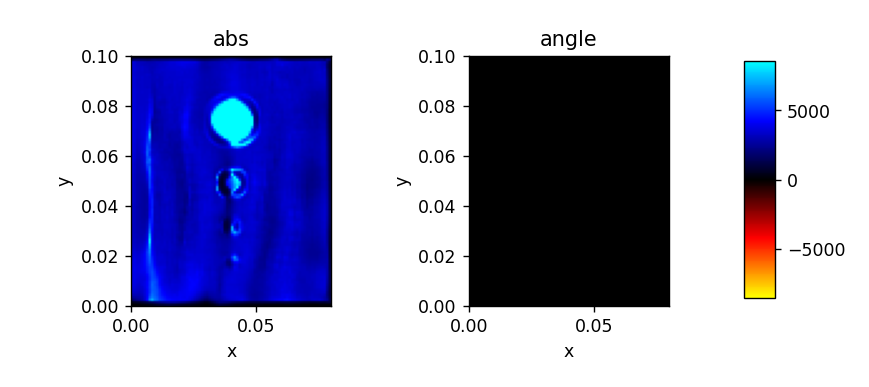

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

In [6]:
%autoreload
example.eval_baseline(frequency=example.wave.frequency.item(), polar=True)
example.view('base', ax_height=2, ax_width=2, col='part', polar=True)

In [7]:
pde = mre_pinn.pde.WaveEquation.from_name('hetero', omega=example.wave.frequency.item(), detach=True)

In [8]:
%autoreload
pinn = mre_pinn.model.MREPINN(
    example,
    omega=15,
    n_layers=4,
    n_hidden=128,
    polar_input=False,
    conditional=False
)
pinn

MREPINN(
  (u_pinn): PINN(
    (hidden0): Linear(in_features=3, out_features=128, bias=True)
    (hidden1): Linear(in_features=131, out_features=128, bias=True)
    (hidden2): Linear(in_features=259, out_features=128, bias=True)
    (output): Linear(in_features=387, out_features=6, bias=True)
  )
  (mu_pinn): PINN(
    (hidden0): Linear(in_features=3, out_features=128, bias=True)
    (hidden1): Linear(in_features=131, out_features=128, bias=True)
    (hidden2): Linear(in_features=259, out_features=128, bias=True)
    (output): Linear(in_features=387, out_features=2, bias=True)
  )
)

In [9]:
%autoreload
model = mre_pinn.training.MREPINNModel(
    example, pinn, pde,
    loss_weights=[1, 0, 1e-8],
    pde_warmup_iters=5000,
    pde_init_weight=1e-8,
    n_points=1024
)
model.compile(optimizer='adam', lr=1e-4, loss=mre_pinn.training.losses.msae_loss)

Compiling model...
'compile' took 0.000210 s



In [10]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False
model.benchmark(100)

# iterations: 100
Data time/iter:  0.0006s (1.07%)
Model time/iter: 0.0050s (9.69%)
Loss time/iter:  0.0464s (89.25%)
Total time/iter: 0.0520s
Total time: 5.1955s
1k iters time: 0.87m
10k iters time: 8.66m
100k iters time: 1.44h


<IPython.core.display.Javascript object>


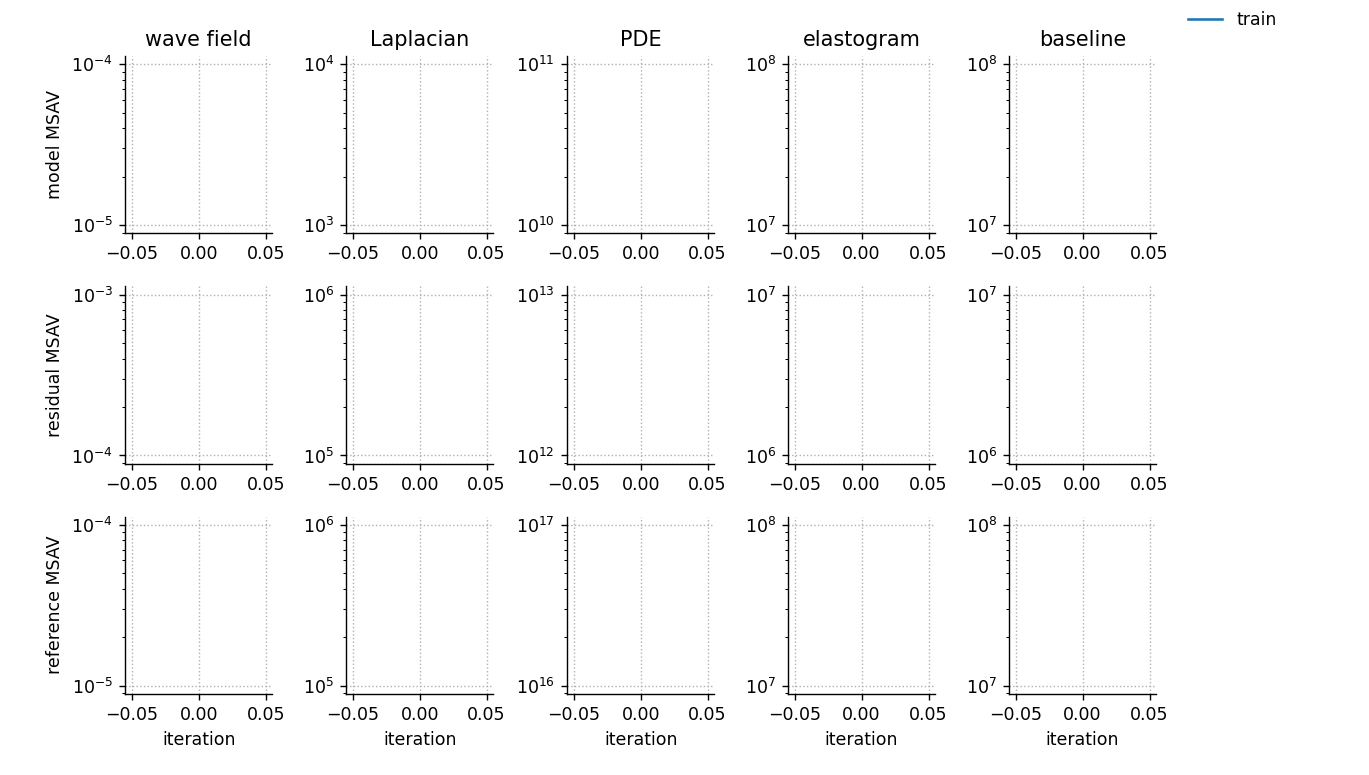

<IPython.core.display.Javascript object>


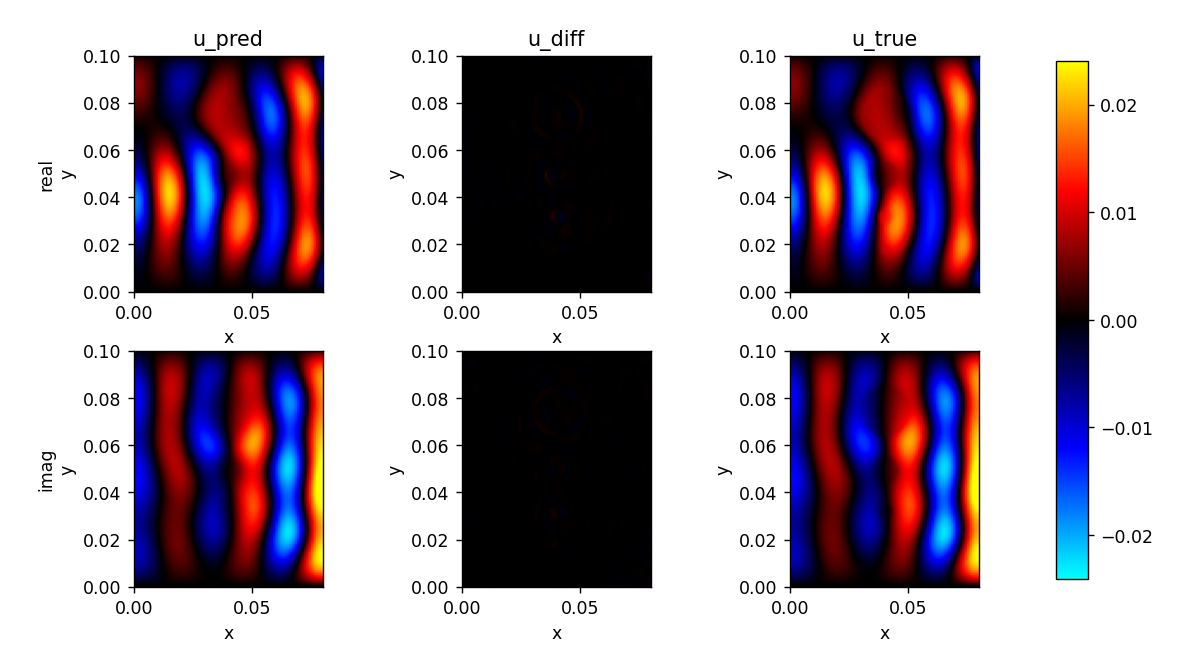

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


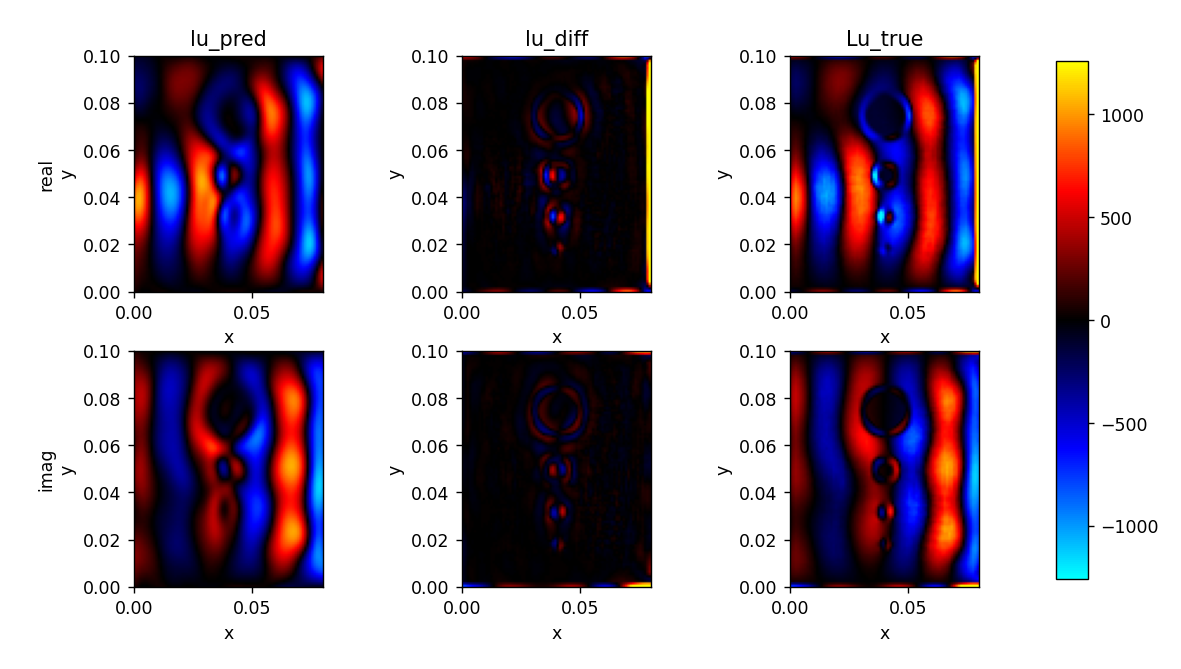

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


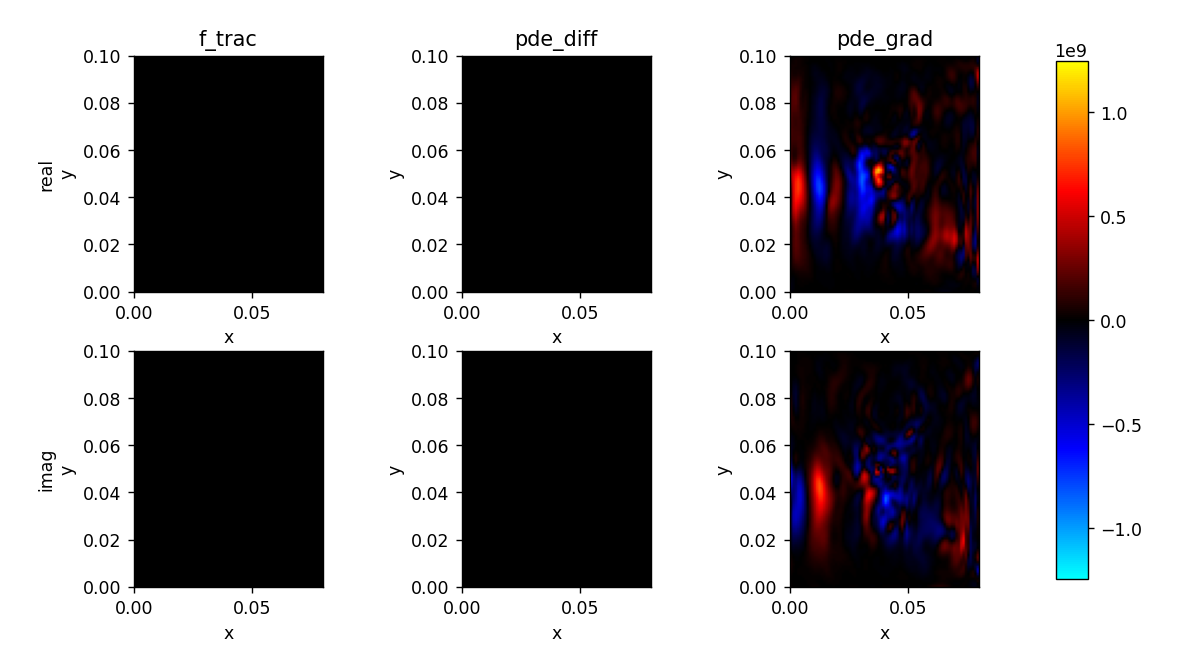

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


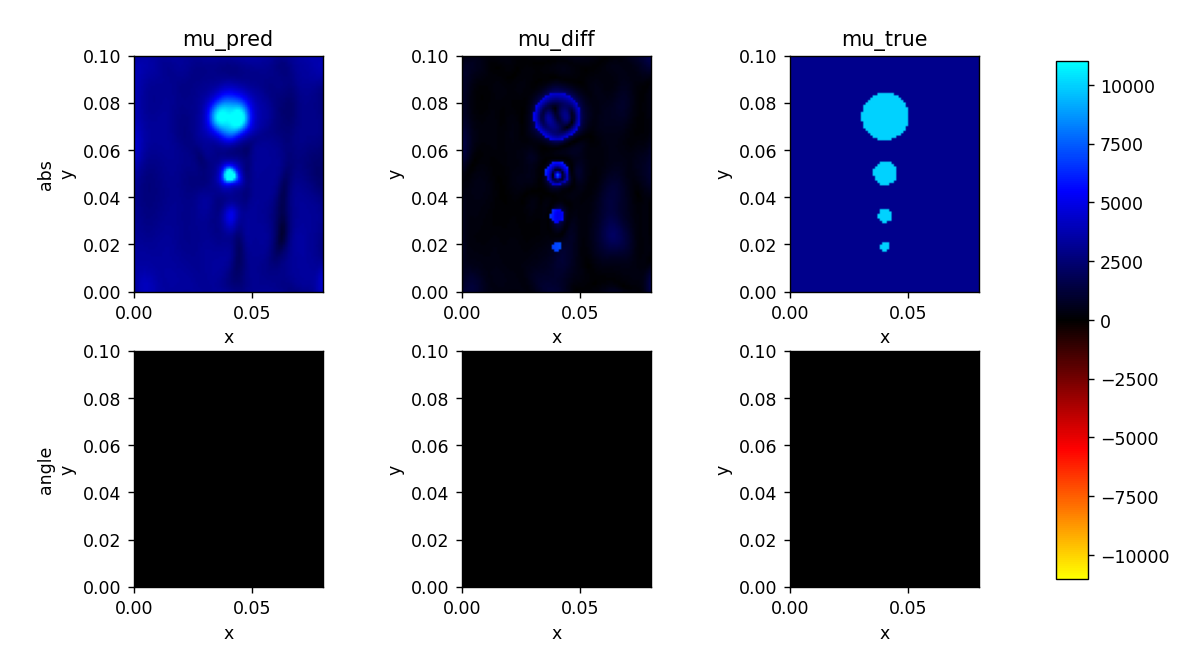

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


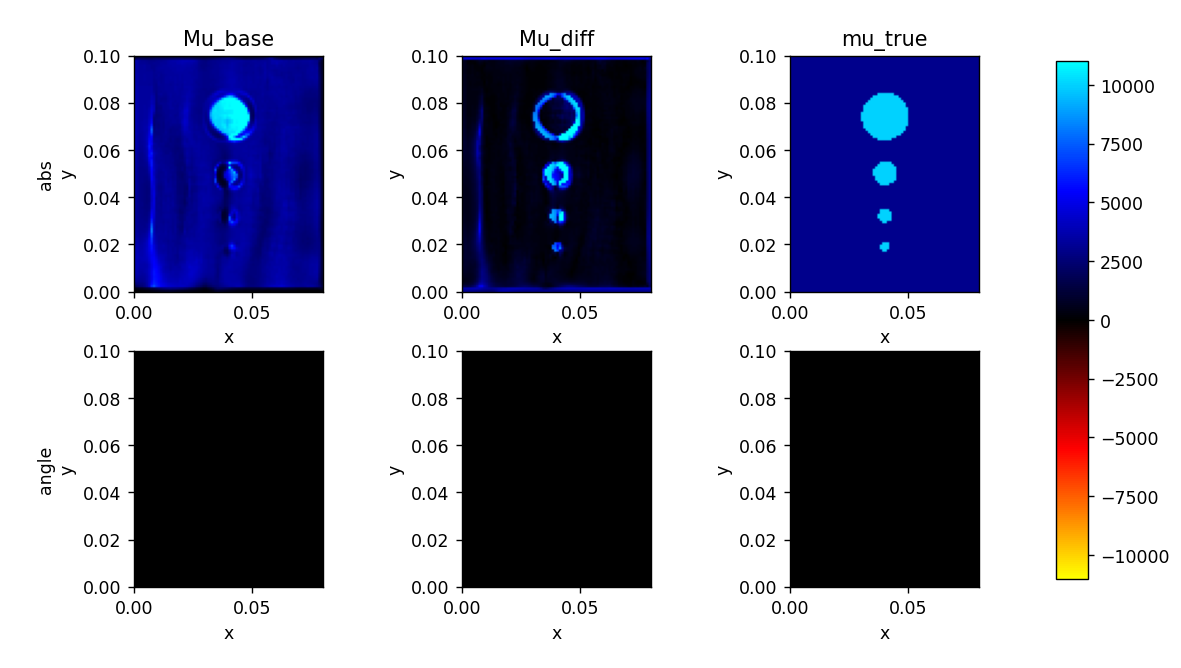

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

In [11]:
test_eval = mre_pinn.testing.TestEvaluator(test_every=100, interact=True)
test_eval.model = model
test_eval.test()

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.44e-04, 0.00e+00, 0.00e+00]    [1.41e-04, 0.00e+00, 0.00e+00]    []  


<IPython.core.display.Javascript object>


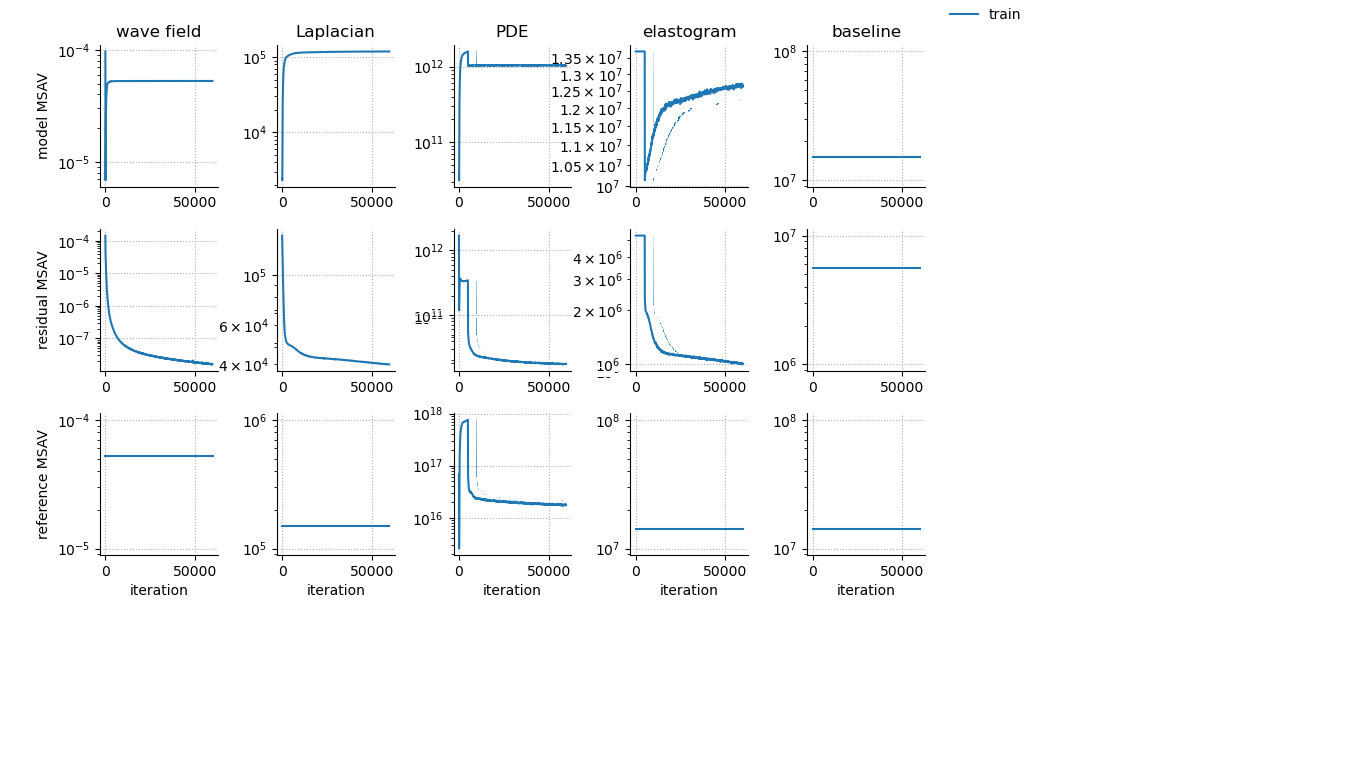

Time spent testing: 13.7550 (24.85%)
10        [8.61e-05, 0.00e+00, 0.00e+00]    [8.14e-05, 0.00e+00, 0.00e+00]    []  
20        [6.49e-05, 0.00e+00, 0.00e+00]    [6.25e-05, 0.00e+00, 0.00e+00]    []  
30        [6.17e-05, 0.00e+00, 0.00e+00]    [5.51e-05, 0.00e+00, 0.00e+00]    []  
40        [5.43e-05, 0.00e+00, 0.00e+00]    [5.01e-05, 0.00e+00, 0.00e+00]    []  
50        [4.94e-05, 0.00e+00, 0.00e+00]    [4.73e-05, 0.00e+00, 0.00e+00]    []  
60        [4.59e-05, 0.00e+00, 0.00e+00]    [4.51e-05, 0.00e+00, 0.00e+00]    []  
70        [4.37e-05, 0.00e+00, 0.00e+00]    [4.32e-05, 0.00e+00, 0.00e+00]    []  
80        [4.32e-05, 0.00e+00, 0.00e+00]    [4.16e-05, 0.00e+00, 0.00e+00]    []  
90        [4.27e-05, 0.00e+00, 0.00e+00]    [3.98e-05, 0.00e+00, 0.00e+00]    []  
100       [3.96e-05, 0.00e+00, 0.00e+00]    [3.84e-05, 0.00e+00, 0.00e+00]    []  
Time spent testing: 12.8842 (35.90%)
110       [3.69e-05, 0.00e+00, 0.00e+00]    [3.69e-05, 0.00e+00, 0.00e+00]    []  
120       [3.

960       [2.65e-06, 0.00e+00, 0.00e+00]    [2.61e-06, 0.00e+00, 0.00e+00]    []  
970       [2.42e-06, 0.00e+00, 0.00e+00]    [2.55e-06, 0.00e+00, 0.00e+00]    []  
980       [2.57e-06, 0.00e+00, 0.00e+00]    [2.51e-06, 0.00e+00, 0.00e+00]    []  
990       [2.42e-06, 0.00e+00, 0.00e+00]    [2.47e-06, 0.00e+00, 0.00e+00]    []  
1000      [2.42e-06, 0.00e+00, 0.00e+00]    [2.41e-06, 0.00e+00, 0.00e+00]    []  
Time spent testing: 13.6908 (58.69%)
1010      [2.47e-06, 0.00e+00, 0.00e+00]    [2.38e-06, 0.00e+00, 0.00e+00]    []  
1020      [2.27e-06, 0.00e+00, 0.00e+00]    [2.32e-06, 0.00e+00, 0.00e+00]    []  
1030      [2.42e-06, 0.00e+00, 0.00e+00]    [2.28e-06, 0.00e+00, 0.00e+00]    []  
1040      [2.32e-06, 0.00e+00, 0.00e+00]    [2.25e-06, 0.00e+00, 0.00e+00]    []  
1050      [2.30e-06, 0.00e+00, 0.00e+00]    [2.21e-06, 0.00e+00, 0.00e+00]    []  
1060      [2.13e-06, 0.00e+00, 0.00e+00]    [2.16e-06, 0.00e+00, 0.00e+00]    []  
1070      [2.13e-06, 0.00e+00, 0.00e+00]    [2.13e

Time spent testing: 11.9431 (62.65%)
1910      [7.12e-07, 0.00e+00, 0.00e+00]    [7.04e-07, 0.00e+00, 0.00e+00]    []  
1920      [6.67e-07, 0.00e+00, 0.00e+00]    [6.96e-07, 0.00e+00, 0.00e+00]    []  
1930      [7.71e-07, 0.00e+00, 0.00e+00]    [6.83e-07, 0.00e+00, 0.00e+00]    []  
1940      [6.97e-07, 0.00e+00, 0.00e+00]    [6.82e-07, 0.00e+00, 0.00e+00]    []  
1950      [6.30e-07, 0.00e+00, 0.00e+00]    [6.78e-07, 0.00e+00, 0.00e+00]    []  
1960      [6.38e-07, 0.00e+00, 0.00e+00]    [6.71e-07, 0.00e+00, 0.00e+00]    []  
1970      [7.31e-07, 0.00e+00, 0.00e+00]    [6.67e-07, 0.00e+00, 0.00e+00]    []  
1980      [6.65e-07, 0.00e+00, 0.00e+00]    [6.60e-07, 0.00e+00, 0.00e+00]    []  
1990      [7.00e-07, 0.00e+00, 0.00e+00]    [6.49e-07, 0.00e+00, 0.00e+00]    []  
2000      [6.63e-07, 0.00e+00, 0.00e+00]    [6.45e-07, 0.00e+00, 0.00e+00]    []  
Time spent testing: 11.9348 (62.90%)
2010      [6.13e-07, 0.00e+00, 0.00e+00]    [6.40e-07, 0.00e+00, 0.00e+00]    []  
2020      [6.

2860      [3.49e-07, 0.00e+00, 0.00e+00]    [3.61e-07, 0.00e+00, 0.00e+00]    []  
2870      [3.38e-07, 0.00e+00, 0.00e+00]    [3.54e-07, 0.00e+00, 0.00e+00]    []  
2880      [3.51e-07, 0.00e+00, 0.00e+00]    [3.57e-07, 0.00e+00, 0.00e+00]    []  
2890      [3.37e-07, 0.00e+00, 0.00e+00]    [3.55e-07, 0.00e+00, 0.00e+00]    []  
2900      [3.64e-07, 0.00e+00, 0.00e+00]    [3.52e-07, 0.00e+00, 0.00e+00]    []  
Time spent testing: 12.0861 (64.51%)
2910      [3.39e-07, 0.00e+00, 0.00e+00]    [3.51e-07, 0.00e+00, 0.00e+00]    []  
2920      [3.36e-07, 0.00e+00, 0.00e+00]    [3.46e-07, 0.00e+00, 0.00e+00]    []  
2930      [3.22e-07, 0.00e+00, 0.00e+00]    [3.47e-07, 0.00e+00, 0.00e+00]    []  
2940      [3.36e-07, 0.00e+00, 0.00e+00]    [3.45e-07, 0.00e+00, 0.00e+00]    []  
2950      [3.21e-07, 0.00e+00, 0.00e+00]    [3.42e-07, 0.00e+00, 0.00e+00]    []  
2960      [3.07e-07, 0.00e+00, 0.00e+00]    [3.38e-07, 0.00e+00, 0.00e+00]    []  
2970      [3.21e-07, 0.00e+00, 0.00e+00]    [3.38e

Time spent testing: 11.7898 (65.44%)
3810      [2.38e-07, 0.00e+00, 0.00e+00]    [2.32e-07, 0.00e+00, 0.00e+00]    []  
3820      [2.23e-07, 0.00e+00, 0.00e+00]    [2.29e-07, 0.00e+00, 0.00e+00]    []  
3830      [2.53e-07, 0.00e+00, 0.00e+00]    [2.27e-07, 0.00e+00, 0.00e+00]    []  
3840      [2.38e-07, 0.00e+00, 0.00e+00]    [2.27e-07, 0.00e+00, 0.00e+00]    []  
3850      [2.20e-07, 0.00e+00, 0.00e+00]    [2.27e-07, 0.00e+00, 0.00e+00]    []  
3860      [3.04e-07, 0.00e+00, 0.00e+00]    [2.28e-07, 0.00e+00, 0.00e+00]    []  
3870      [2.29e-07, 0.00e+00, 0.00e+00]    [2.27e-07, 0.00e+00, 0.00e+00]    []  
3880      [2.44e-07, 0.00e+00, 0.00e+00]    [2.25e-07, 0.00e+00, 0.00e+00]    []  
3890      [2.40e-07, 0.00e+00, 0.00e+00]    [2.24e-07, 0.00e+00, 0.00e+00]    []  
3900      [2.15e-07, 0.00e+00, 0.00e+00]    [2.22e-07, 0.00e+00, 0.00e+00]    []  
Time spent testing: 11.8780 (65.52%)
3910      [2.32e-07, 0.00e+00, 0.00e+00]    [2.22e-07, 0.00e+00, 0.00e+00]    []  
3920      [2.

4760      [1.83e-07, 0.00e+00, 0.00e+00]    [1.70e-07, 0.00e+00, 0.00e+00]    []  
4770      [1.72e-07, 0.00e+00, 0.00e+00]    [1.63e-07, 0.00e+00, 0.00e+00]    []  
4780      [1.79e-07, 0.00e+00, 0.00e+00]    [1.62e-07, 0.00e+00, 0.00e+00]    []  
4790      [1.81e-07, 0.00e+00, 0.00e+00]    [1.65e-07, 0.00e+00, 0.00e+00]    []  
4800      [1.52e-07, 0.00e+00, 0.00e+00]    [1.64e-07, 0.00e+00, 0.00e+00]    []  
Time spent testing: 12.5875 (65.90%)
4810      [1.63e-07, 0.00e+00, 0.00e+00]    [1.63e-07, 0.00e+00, 0.00e+00]    []  
4820      [1.77e-07, 0.00e+00, 0.00e+00]    [1.61e-07, 0.00e+00, 0.00e+00]    []  
4830      [1.70e-07, 0.00e+00, 0.00e+00]    [1.62e-07, 0.00e+00, 0.00e+00]    []  
4840      [1.58e-07, 0.00e+00, 0.00e+00]    [1.64e-07, 0.00e+00, 0.00e+00]    []  
4850      [1.73e-07, 0.00e+00, 0.00e+00]    [1.61e-07, 0.00e+00, 0.00e+00]    []  
4860      [1.71e-07, 0.00e+00, 0.00e+00]    [1.60e-07, 0.00e+00, 0.00e+00]    []  
4870      [1.42e-07, 0.00e+00, 0.00e+00]    [1.58e

Time spent testing: 12.7477 (66.16%)
5710      [1.54e-07, 0.00e+00, 3.84e+02]    [1.25e-07, 0.00e+00, 3.65e+02]    []  
5720      [1.30e-07, 0.00e+00, 3.45e+02]    [1.25e-07, 0.00e+00, 3.66e+02]    []  
5730      [1.30e-07, 0.00e+00, 3.46e+02]    [1.25e-07, 0.00e+00, 3.66e+02]    []  
5740      [1.24e-07, 0.00e+00, 3.56e+02]    [1.25e-07, 0.00e+00, 3.63e+02]    []  
5750      [1.35e-07, 0.00e+00, 3.46e+02]    [1.25e-07, 0.00e+00, 3.65e+02]    []  
5760      [1.31e-07, 0.00e+00, 3.30e+02]    [1.23e-07, 0.00e+00, 3.61e+02]    []  
5770      [1.22e-07, 0.00e+00, 3.44e+02]    [1.22e-07, 0.00e+00, 3.63e+02]    []  
5780      [1.30e-07, 0.00e+00, 3.46e+02]    [1.22e-07, 0.00e+00, 3.62e+02]    []  
5790      [1.32e-07, 0.00e+00, 3.59e+02]    [1.23e-07, 0.00e+00, 3.61e+02]    []  
5800      [1.13e-07, 0.00e+00, 3.36e+02]    [1.24e-07, 0.00e+00, 3.58e+02]    []  
Time spent testing: 12.8668 (66.21%)
5810      [1.19e-07, 0.00e+00, 3.45e+02]    [1.23e-07, 0.00e+00, 3.59e+02]    []  
5820      [1.

6660      [1.10e-07, 0.00e+00, 3.11e+02]    [1.06e-07, 0.00e+00, 3.08e+02]    []  
6670      [1.07e-07, 0.00e+00, 3.04e+02]    [1.01e-07, 0.00e+00, 3.06e+02]    []  
6680      [1.11e-07, 0.00e+00, 3.00e+02]    [9.93e-08, 0.00e+00, 3.04e+02]    []  
6690      [9.67e-08, 0.00e+00, 3.05e+02]    [1.02e-07, 0.00e+00, 3.05e+02]    []  
6700      [1.19e-07, 0.00e+00, 2.91e+02]    [1.01e-07, 0.00e+00, 3.02e+02]    []  
Time spent testing: 12.5346 (66.40%)
6710      [9.53e-08, 0.00e+00, 2.90e+02]    [1.01e-07, 0.00e+00, 3.03e+02]    []  
6720      [1.05e-07, 0.00e+00, 3.12e+02]    [1.02e-07, 0.00e+00, 3.05e+02]    []  
6730      [9.39e-08, 0.00e+00, 2.99e+02]    [1.02e-07, 0.00e+00, 3.03e+02]    []  
6740      [1.13e-07, 0.00e+00, 2.96e+02]    [9.94e-08, 0.00e+00, 3.04e+02]    []  
6750      [9.56e-08, 0.00e+00, 3.00e+02]    [1.00e-07, 0.00e+00, 3.00e+02]    []  
6760      [1.13e-07, 0.00e+00, 2.95e+02]    [1.00e-07, 0.00e+00, 3.03e+02]    []  
6770      [9.93e-08, 0.00e+00, 3.04e+02]    [9.82e

Time spent testing: 12.6209 (66.56%)
7610      [8.85e-08, 0.00e+00, 2.74e+02]    [8.46e-08, 0.00e+00, 2.69e+02]    []  
7620      [9.13e-08, 0.00e+00, 2.60e+02]    [8.72e-08, 0.00e+00, 2.73e+02]    []  
7630      [9.38e-08, 0.00e+00, 2.76e+02]    [8.58e-08, 0.00e+00, 2.73e+02]    []  
7640      [9.99e-08, 0.00e+00, 2.87e+02]    [8.41e-08, 0.00e+00, 2.68e+02]    []  
7650      [8.48e-08, 0.00e+00, 2.73e+02]    [8.53e-08, 0.00e+00, 2.69e+02]    []  
7660      [7.77e-08, 0.00e+00, 2.74e+02]    [8.65e-08, 0.00e+00, 2.72e+02]    []  
7670      [8.76e-08, 0.00e+00, 2.67e+02]    [8.70e-08, 0.00e+00, 2.68e+02]    []  
7680      [9.23e-08, 0.00e+00, 2.68e+02]    [8.86e-08, 0.00e+00, 2.64e+02]    []  
7690      [8.65e-08, 0.00e+00, 2.67e+02]    [8.46e-08, 0.00e+00, 2.68e+02]    []  
7700      [8.18e-08, 0.00e+00, 2.66e+02]    [8.49e-08, 0.00e+00, 2.70e+02]    []  
Time spent testing: 12.5521 (66.56%)
7710      [9.36e-08, 0.00e+00, 2.72e+02]    [8.41e-08, 0.00e+00, 2.68e+02]    []  
7720      [8.

8560      [8.60e-08, 0.00e+00, 2.32e+02]    [7.52e-08, 0.00e+00, 2.52e+02]    []  
8570      [7.29e-08, 0.00e+00, 2.46e+02]    [7.46e-08, 0.00e+00, 2.49e+02]    []  
8580      [7.28e-08, 0.00e+00, 2.46e+02]    [7.45e-08, 0.00e+00, 2.50e+02]    []  
8590      [7.40e-08, 0.00e+00, 2.49e+02]    [7.40e-08, 0.00e+00, 2.54e+02]    []  
8600      [8.11e-08, 0.00e+00, 2.66e+02]    [7.27e-08, 0.00e+00, 2.53e+02]    []  
Time spent testing: 13.1563 (66.63%)
8610      [7.14e-08, 0.00e+00, 2.49e+02]    [7.31e-08, 0.00e+00, 2.51e+02]    []  
8620      [7.07e-08, 0.00e+00, 2.49e+02]    [7.36e-08, 0.00e+00, 2.50e+02]    []  
8630      [7.72e-08, 0.00e+00, 2.57e+02]    [7.38e-08, 0.00e+00, 2.54e+02]    []  
8640      [7.35e-08, 0.00e+00, 2.29e+02]    [7.27e-08, 0.00e+00, 2.53e+02]    []  
8650      [7.12e-08, 0.00e+00, 2.45e+02]    [7.37e-08, 0.00e+00, 2.51e+02]    []  
8660      [7.76e-08, 0.00e+00, 2.41e+02]    [7.29e-08, 0.00e+00, 2.50e+02]    []  
8670      [7.32e-08, 0.00e+00, 2.44e+02]    [7.25e

Time spent testing: 12.5970 (66.73%)
9510      [6.66e-08, 0.00e+00, 2.27e+02]    [6.63e-08, 0.00e+00, 2.43e+02]    []  
9520      [6.59e-08, 0.00e+00, 2.37e+02]    [6.73e-08, 0.00e+00, 2.46e+02]    []  
9530      [7.29e-08, 0.00e+00, 2.51e+02]    [6.69e-08, 0.00e+00, 2.43e+02]    []  
9540      [6.41e-08, 0.00e+00, 2.20e+02]    [6.48e-08, 0.00e+00, 2.43e+02]    []  
9550      [6.40e-08, 0.00e+00, 2.50e+02]    [6.58e-08, 0.00e+00, 2.45e+02]    []  
9560      [5.52e-08, 0.00e+00, 2.23e+02]    [6.52e-08, 0.00e+00, 2.46e+02]    []  
9570      [6.37e-08, 0.00e+00, 2.31e+02]    [6.38e-08, 0.00e+00, 2.44e+02]    []  
9580      [6.70e-08, 0.00e+00, 2.47e+02]    [6.59e-08, 0.00e+00, 2.46e+02]    []  
9590      [7.50e-08, 0.00e+00, 2.39e+02]    [6.38e-08, 0.00e+00, 2.43e+02]    []  
9600      [6.44e-08, 0.00e+00, 2.37e+02]    [6.51e-08, 0.00e+00, 2.45e+02]    []  
Time spent testing: 12.9593 (66.75%)
9610      [6.70e-08, 0.00e+00, 2.29e+02]    [6.57e-08, 0.00e+00, 2.42e+02]    []  
9620      [6.

10460     [5.95e-08, 0.00e+00, 2.36e+02]    [5.83e-08, 0.00e+00, 2.39e+02]    []  
10470     [6.11e-08, 0.00e+00, 2.34e+02]    [5.78e-08, 0.00e+00, 2.38e+02]    []  
10480     [6.90e-08, 0.00e+00, 2.51e+02]    [5.78e-08, 0.00e+00, 2.40e+02]    []  
10490     [5.84e-08, 0.00e+00, 2.26e+02]    [5.78e-08, 0.00e+00, 2.35e+02]    []  
10500     [5.88e-08, 0.00e+00, 2.20e+02]    [5.79e-08, 0.00e+00, 2.39e+02]    []  
Time spent testing: 12.8705 (66.83%)
10510     [5.97e-08, 0.00e+00, 2.21e+02]    [5.95e-08, 0.00e+00, 2.39e+02]    []  
10520     [6.29e-08, 0.00e+00, 2.39e+02]    [5.81e-08, 0.00e+00, 2.41e+02]    []  
10530     [5.94e-08, 0.00e+00, 2.40e+02]    [5.75e-08, 0.00e+00, 2.37e+02]    []  
10540     [6.17e-08, 0.00e+00, 2.27e+02]    [5.81e-08, 0.00e+00, 2.41e+02]    []  
10550     [5.38e-08, 0.00e+00, 2.30e+02]    [5.87e-08, 0.00e+00, 2.40e+02]    []  
10560     [6.68e-08, 0.00e+00, 2.45e+02]    [5.77e-08, 0.00e+00, 2.40e+02]    []  
10570     [6.21e-08, 0.00e+00, 2.44e+02]    [5.76e

Time spent testing: 13.2266 (66.88%)
11410     [5.13e-08, 0.00e+00, 2.23e+02]    [5.21e-08, 0.00e+00, 2.35e+02]    []  
11420     [5.53e-08, 0.00e+00, 2.22e+02]    [5.31e-08, 0.00e+00, 2.35e+02]    []  
11430     [5.33e-08, 0.00e+00, 2.28e+02]    [5.23e-08, 0.00e+00, 2.36e+02]    []  
11440     [5.27e-08, 0.00e+00, 2.40e+02]    [5.20e-08, 0.00e+00, 2.39e+02]    []  
11450     [5.27e-08, 0.00e+00, 2.35e+02]    [5.28e-08, 0.00e+00, 2.37e+02]    []  
11460     [5.19e-08, 0.00e+00, 2.35e+02]    [5.15e-08, 0.00e+00, 2.36e+02]    []  
11470     [5.11e-08, 0.00e+00, 2.27e+02]    [5.26e-08, 0.00e+00, 2.33e+02]    []  
11480     [5.06e-08, 0.00e+00, 2.33e+02]    [5.25e-08, 0.00e+00, 2.38e+02]    []  
11490     [5.20e-08, 0.00e+00, 2.20e+02]    [5.19e-08, 0.00e+00, 2.39e+02]    []  
11500     [4.56e-08, 0.00e+00, 2.19e+02]    [5.26e-08, 0.00e+00, 2.38e+02]    []  
Time spent testing: 12.6993 (66.88%)
11510     [5.50e-08, 0.00e+00, 2.34e+02]    [5.14e-08, 0.00e+00, 2.35e+02]    []  
11520     [5.

12360     [5.51e-08, 0.00e+00, 2.23e+02]    [4.98e-08, 0.00e+00, 2.31e+02]    []  
12370     [5.40e-08, 0.00e+00, 2.21e+02]    [4.87e-08, 0.00e+00, 2.34e+02]    []  
12380     [5.11e-08, 0.00e+00, 2.33e+02]    [4.92e-08, 0.00e+00, 2.31e+02]    []  
12390     [4.79e-08, 0.00e+00, 2.16e+02]    [5.09e-08, 0.00e+00, 2.33e+02]    []  
12400     [5.17e-08, 0.00e+00, 2.37e+02]    [4.89e-08, 0.00e+00, 2.37e+02]    []  
Time spent testing: 12.5342 (66.96%)
12410     [5.45e-08, 0.00e+00, 2.37e+02]    [4.89e-08, 0.00e+00, 2.35e+02]    []  
12420     [5.24e-08, 0.00e+00, 2.11e+02]    [4.94e-08, 0.00e+00, 2.37e+02]    []  
12430     [5.63e-08, 0.00e+00, 2.29e+02]    [4.98e-08, 0.00e+00, 2.34e+02]    []  
12440     [5.44e-08, 0.00e+00, 2.21e+02]    [4.86e-08, 0.00e+00, 2.34e+02]    []  
12450     [5.19e-08, 0.00e+00, 2.42e+02]    [4.83e-08, 0.00e+00, 2.32e+02]    []  
12460     [5.04e-08, 0.00e+00, 2.26e+02]    [4.90e-08, 0.00e+00, 2.39e+02]    []  
12470     [5.29e-08, 0.00e+00, 2.36e+02]    [4.84e

Time spent testing: 12.5158 (67.02%)
13310     [4.69e-08, 0.00e+00, 2.28e+02]    [4.76e-08, 0.00e+00, 2.33e+02]    []  
13320     [4.92e-08, 0.00e+00, 2.24e+02]    [4.56e-08, 0.00e+00, 2.32e+02]    []  
13330     [4.73e-08, 0.00e+00, 2.33e+02]    [4.56e-08, 0.00e+00, 2.34e+02]    []  
13340     [4.59e-08, 0.00e+00, 2.32e+02]    [4.47e-08, 0.00e+00, 2.30e+02]    []  
13350     [4.63e-08, 0.00e+00, 2.23e+02]    [4.44e-08, 0.00e+00, 2.28e+02]    []  
13360     [4.77e-08, 0.00e+00, 2.12e+02]    [4.52e-08, 0.00e+00, 2.31e+02]    []  
13370     [4.51e-08, 0.00e+00, 2.29e+02]    [4.41e-08, 0.00e+00, 2.29e+02]    []  
13380     [4.89e-08, 0.00e+00, 2.30e+02]    [4.49e-08, 0.00e+00, 2.28e+02]    []  
13390     [4.81e-08, 0.00e+00, 2.38e+02]    [4.51e-08, 0.00e+00, 2.28e+02]    []  
13400     [5.23e-08, 0.00e+00, 2.38e+02]    [4.46e-08, 0.00e+00, 2.32e+02]    []  
Time spent testing: 12.9008 (67.03%)
13410     [5.70e-08, 0.00e+00, 2.23e+02]    [4.49e-08, 0.00e+00, 2.29e+02]    []  
13420     [5.

14260     [4.27e-08, 0.00e+00, 2.24e+02]    [4.27e-08, 0.00e+00, 2.24e+02]    []  
14270     [4.36e-08, 0.00e+00, 2.04e+02]    [4.25e-08, 0.00e+00, 2.24e+02]    []  
14280     [4.16e-08, 0.00e+00, 2.22e+02]    [4.21e-08, 0.00e+00, 2.28e+02]    []  
14290     [4.37e-08, 0.00e+00, 2.18e+02]    [4.38e-08, 0.00e+00, 2.25e+02]    []  
14300     [5.13e-08, 0.00e+00, 2.10e+02]    [4.26e-08, 0.00e+00, 2.29e+02]    []  
Time spent testing: 13.5915 (67.07%)
14310     [4.27e-08, 0.00e+00, 2.24e+02]    [4.28e-08, 0.00e+00, 2.29e+02]    []  
14320     [4.55e-08, 0.00e+00, 2.14e+02]    [4.20e-08, 0.00e+00, 2.26e+02]    []  
14330     [4.75e-08, 0.00e+00, 2.31e+02]    [4.32e-08, 0.00e+00, 2.24e+02]    []  
14340     [4.39e-08, 0.00e+00, 2.10e+02]    [4.18e-08, 0.00e+00, 2.28e+02]    []  
14350     [4.71e-08, 0.00e+00, 2.00e+02]    [4.23e-08, 0.00e+00, 2.28e+02]    []  
14360     [4.81e-08, 0.00e+00, 2.20e+02]    [4.32e-08, 0.00e+00, 2.28e+02]    []  
14370     [4.20e-08, 0.00e+00, 2.11e+02]    [4.24e

Time spent testing: 13.6747 (67.06%)
15210     [4.68e-08, 0.00e+00, 2.23e+02]    [3.97e-08, 0.00e+00, 2.24e+02]    []  
15220     [4.20e-08, 0.00e+00, 2.23e+02]    [4.00e-08, 0.00e+00, 2.24e+02]    []  
15230     [4.56e-08, 0.00e+00, 2.18e+02]    [3.94e-08, 0.00e+00, 2.27e+02]    []  
15240     [3.86e-08, 0.00e+00, 2.16e+02]    [4.19e-08, 0.00e+00, 2.25e+02]    []  
15250     [3.95e-08, 0.00e+00, 2.16e+02]    [4.04e-08, 0.00e+00, 2.25e+02]    []  
15260     [3.75e-08, 0.00e+00, 2.07e+02]    [4.04e-08, 0.00e+00, 2.22e+02]    []  
15270     [4.39e-08, 0.00e+00, 2.15e+02]    [4.04e-08, 0.00e+00, 2.23e+02]    []  
15280     [4.39e-08, 0.00e+00, 2.22e+02]    [3.94e-08, 0.00e+00, 2.25e+02]    []  
15290     [1.09e-07, 0.00e+00, 2.21e+02]    [3.97e-08, 0.00e+00, 2.25e+02]    []  
15300     [4.18e-08, 0.00e+00, 2.19e+02]    [4.01e-08, 0.00e+00, 2.24e+02]    []  
Time spent testing: 13.6163 (67.03%)
15310     [4.50e-08, 0.00e+00, 2.19e+02]    [3.95e-08, 0.00e+00, 2.25e+02]    []  
15320     [4.

16160     [3.48e-08, 0.00e+00, 2.22e+02]    [3.83e-08, 0.00e+00, 2.21e+02]    []  
16170     [4.42e-08, 0.00e+00, 2.17e+02]    [3.79e-08, 0.00e+00, 2.20e+02]    []  
16180     [3.58e-08, 0.00e+00, 2.01e+02]    [3.77e-08, 0.00e+00, 2.23e+02]    []  
16190     [4.16e-08, 0.00e+00, 2.16e+02]    [3.73e-08, 0.00e+00, 2.21e+02]    []  
16200     [4.08e-08, 0.00e+00, 2.31e+02]    [3.74e-08, 0.00e+00, 2.22e+02]    []  
Time spent testing: 13.7067 (67.03%)
16210     [4.07e-08, 0.00e+00, 2.20e+02]    [3.76e-08, 0.00e+00, 2.25e+02]    []  
16220     [3.77e-08, 0.00e+00, 2.12e+02]    [3.84e-08, 0.00e+00, 2.24e+02]    []  
16230     [3.91e-08, 0.00e+00, 2.09e+02]    [3.80e-08, 0.00e+00, 2.20e+02]    []  
16240     [3.83e-08, 0.00e+00, 2.18e+02]    [3.79e-08, 0.00e+00, 2.21e+02]    []  
16250     [3.71e-08, 0.00e+00, 2.18e+02]    [3.74e-08, 0.00e+00, 2.20e+02]    []  
16260     [4.23e-08, 0.00e+00, 2.07e+02]    [3.80e-08, 0.00e+00, 2.21e+02]    []  
16270     [4.29e-08, 0.00e+00, 2.05e+02]    [3.84e

Time spent testing: 13.9612 (67.04%)
17110     [3.30e-08, 0.00e+00, 2.16e+02]    [3.58e-08, 0.00e+00, 2.23e+02]    []  
17120     [4.00e-08, 0.00e+00, 2.15e+02]    [3.62e-08, 0.00e+00, 2.20e+02]    []  
17130     [3.76e-08, 0.00e+00, 2.17e+02]    [3.69e-08, 0.00e+00, 2.20e+02]    []  
17140     [3.84e-08, 0.00e+00, 2.01e+02]    [3.55e-08, 0.00e+00, 2.18e+02]    []  
17150     [3.63e-08, 0.00e+00, 2.15e+02]    [3.66e-08, 0.00e+00, 2.17e+02]    []  
17160     [3.70e-08, 0.00e+00, 2.23e+02]    [3.58e-08, 0.00e+00, 2.19e+02]    []  
17170     [3.70e-08, 0.00e+00, 2.24e+02]    [3.58e-08, 0.00e+00, 2.17e+02]    []  
17180     [3.81e-08, 0.00e+00, 2.12e+02]    [3.58e-08, 0.00e+00, 2.21e+02]    []  
17190     [3.42e-08, 0.00e+00, 2.13e+02]    [3.73e-08, 0.00e+00, 2.23e+02]    []  
17200     [4.14e-08, 0.00e+00, 2.07e+02]    [3.59e-08, 0.00e+00, 2.19e+02]    []  
Time spent testing: 13.7846 (67.04%)
17210     [3.83e-08, 0.00e+00, 2.28e+02]    [3.60e-08, 0.00e+00, 2.21e+02]    []  
17220     [3.

18060     [3.61e-08, 0.00e+00, 2.11e+02]    [3.55e-08, 0.00e+00, 2.18e+02]    []  
18070     [3.77e-08, 0.00e+00, 2.11e+02]    [3.57e-08, 0.00e+00, 2.20e+02]    []  
18080     [3.76e-08, 0.00e+00, 2.09e+02]    [3.43e-08, 0.00e+00, 2.19e+02]    []  
18090     [3.26e-08, 0.00e+00, 2.13e+02]    [3.46e-08, 0.00e+00, 2.21e+02]    []  
18100     [3.27e-08, 0.00e+00, 1.96e+02]    [3.49e-08, 0.00e+00, 2.22e+02]    []  
Time spent testing: 13.8883 (67.05%)
18110     [4.16e-08, 0.00e+00, 2.07e+02]    [3.45e-08, 0.00e+00, 2.21e+02]    []  
18120     [3.11e-08, 0.00e+00, 2.00e+02]    [3.47e-08, 0.00e+00, 2.20e+02]    []  
18130     [3.55e-08, 0.00e+00, 2.02e+02]    [3.44e-08, 0.00e+00, 2.20e+02]    []  
18140     [3.79e-08, 0.00e+00, 2.03e+02]    [3.42e-08, 0.00e+00, 2.18e+02]    []  
18150     [3.74e-08, 0.00e+00, 2.19e+02]    [3.52e-08, 0.00e+00, 2.20e+02]    []  
18160     [3.54e-08, 0.00e+00, 2.15e+02]    [3.42e-08, 0.00e+00, 2.17e+02]    []  
18170     [3.62e-08, 0.00e+00, 2.15e+02]    [3.35e

Time spent testing: 13.9551 (67.05%)
19010     [3.24e-08, 0.00e+00, 2.30e+02]    [3.19e-08, 0.00e+00, 2.15e+02]    []  
19020     [3.96e-08, 0.00e+00, 2.08e+02]    [3.29e-08, 0.00e+00, 2.12e+02]    []  
19030     [3.41e-08, 0.00e+00, 2.04e+02]    [3.20e-08, 0.00e+00, 2.12e+02]    []  
19040     [3.29e-08, 0.00e+00, 2.14e+02]    [3.30e-08, 0.00e+00, 2.15e+02]    []  
19050     [3.34e-08, 0.00e+00, 2.10e+02]    [3.38e-08, 0.00e+00, 2.17e+02]    []  
19060     [3.51e-08, 0.00e+00, 2.22e+02]    [3.34e-08, 0.00e+00, 2.21e+02]    []  
19070     [4.08e-08, 0.00e+00, 2.00e+02]    [3.36e-08, 0.00e+00, 2.15e+02]    []  
19080     [1.03e-07, 0.00e+00, 2.25e+02]    [3.37e-08, 0.00e+00, 2.14e+02]    []  
19090     [4.12e-08, 0.00e+00, 2.05e+02]    [3.36e-08, 0.00e+00, 2.16e+02]    []  
19100     [3.49e-08, 0.00e+00, 2.13e+02]    [3.26e-08, 0.00e+00, 2.12e+02]    []  
Time spent testing: 14.1563 (67.05%)
19110     [4.06e-08, 0.00e+00, 2.13e+02]    [3.32e-08, 0.00e+00, 2.14e+02]    []  
19120     [3.

19960     [3.10e-08, 0.00e+00, 2.01e+02]    [3.08e-08, 0.00e+00, 2.15e+02]    []  
19970     [3.79e-08, 0.00e+00, 2.01e+02]    [3.21e-08, 0.00e+00, 2.18e+02]    []  
19980     [3.29e-08, 0.00e+00, 2.20e+02]    [3.13e-08, 0.00e+00, 2.17e+02]    []  
19990     [3.64e-08, 0.00e+00, 1.97e+02]    [3.11e-08, 0.00e+00, 2.14e+02]    []  
20000     [3.04e-08, 0.00e+00, 2.00e+02]    [3.26e-08, 0.00e+00, 2.11e+02]    []  
Time spent testing: 13.4531 (67.04%)
20010     [4.31e-08, 0.00e+00, 2.10e+02]    [3.17e-08, 0.00e+00, 2.16e+02]    []  
20020     [3.24e-08, 0.00e+00, 2.07e+02]    [3.20e-08, 0.00e+00, 2.16e+02]    []  
20030     [2.98e-08, 0.00e+00, 1.88e+02]    [3.16e-08, 0.00e+00, 2.17e+02]    []  
20040     [3.55e-08, 0.00e+00, 2.14e+02]    [3.13e-08, 0.00e+00, 2.15e+02]    []  
20050     [3.47e-08, 0.00e+00, 2.00e+02]    [3.26e-08, 0.00e+00, 2.16e+02]    []  
20060     [3.39e-08, 0.00e+00, 2.11e+02]    [3.21e-08, 0.00e+00, 2.17e+02]    []  
20070     [3.24e-08, 0.00e+00, 1.91e+02]    [3.14e

Time spent testing: 13.4935 (67.05%)
20910     [3.13e-08, 0.00e+00, 2.03e+02]    [3.07e-08, 0.00e+00, 2.10e+02]    []  
20920     [3.04e-08, 0.00e+00, 2.24e+02]    [3.02e-08, 0.00e+00, 2.12e+02]    []  
20930     [3.12e-08, 0.00e+00, 2.03e+02]    [2.96e-08, 0.00e+00, 2.11e+02]    []  
20940     [3.05e-08, 0.00e+00, 1.97e+02]    [3.02e-08, 0.00e+00, 2.11e+02]    []  
20950     [3.71e-08, 0.00e+00, 2.17e+02]    [3.07e-08, 0.00e+00, 2.11e+02]    []  
20960     [2.84e-08, 0.00e+00, 2.14e+02]    [2.95e-08, 0.00e+00, 2.09e+02]    []  
20970     [3.10e-08, 0.00e+00, 2.07e+02]    [3.00e-08, 0.00e+00, 2.14e+02]    []  
20980     [3.31e-08, 0.00e+00, 2.06e+02]    [3.02e-08, 0.00e+00, 2.13e+02]    []  
20990     [3.71e-08, 0.00e+00, 1.99e+02]    [3.01e-08, 0.00e+00, 2.10e+02]    []  
21000     [3.33e-08, 0.00e+00, 1.96e+02]    [3.01e-08, 0.00e+00, 2.11e+02]    []  
Time spent testing: 13.9016 (67.06%)
21010     [3.08e-08, 0.00e+00, 2.09e+02]    [3.00e-08, 0.00e+00, 2.11e+02]    []  
21020     [3.

21860     [3.26e-08, 0.00e+00, 2.06e+02]    [2.95e-08, 0.00e+00, 2.13e+02]    []  
21870     [3.51e-08, 0.00e+00, 2.11e+02]    [2.88e-08, 0.00e+00, 2.09e+02]    []  
21880     [2.82e-08, 0.00e+00, 2.10e+02]    [2.91e-08, 0.00e+00, 2.10e+02]    []  
21890     [3.07e-08, 0.00e+00, 2.11e+02]    [2.92e-08, 0.00e+00, 2.07e+02]    []  
21900     [2.74e-08, 0.00e+00, 2.08e+02]    [2.98e-08, 0.00e+00, 2.12e+02]    []  
Time spent testing: 13.8776 (67.08%)
21910     [3.00e-08, 0.00e+00, 1.95e+02]    [3.10e-08, 0.00e+00, 2.09e+02]    []  
21920     [2.91e-08, 0.00e+00, 1.85e+02]    [3.03e-08, 0.00e+00, 2.11e+02]    []  
21930     [3.04e-08, 0.00e+00, 2.07e+02]    [2.97e-08, 0.00e+00, 2.09e+02]    []  
21940     [3.36e-08, 0.00e+00, 2.07e+02]    [2.88e-08, 0.00e+00, 2.10e+02]    []  
21950     [3.25e-08, 0.00e+00, 2.03e+02]    [2.90e-08, 0.00e+00, 2.12e+02]    []  
21960     [3.18e-08, 0.00e+00, 2.17e+02]    [3.02e-08, 0.00e+00, 2.11e+02]    []  
21970     [3.10e-08, 0.00e+00, 2.03e+02]    [2.92e

Time spent testing: 13.9505 (67.09%)
22810     [3.45e-08, 0.00e+00, 2.08e+02]    [2.83e-08, 0.00e+00, 2.09e+02]    []  
22820     [2.86e-08, 0.00e+00, 1.89e+02]    [2.93e-08, 0.00e+00, 2.12e+02]    []  
22830     [3.44e-08, 0.00e+00, 2.23e+02]    [2.81e-08, 0.00e+00, 2.08e+02]    []  
22840     [2.67e-08, 0.00e+00, 2.04e+02]    [2.90e-08, 0.00e+00, 2.08e+02]    []  
22850     [2.71e-08, 0.00e+00, 1.96e+02]    [2.84e-08, 0.00e+00, 2.10e+02]    []  
22860     [3.39e-08, 0.00e+00, 1.98e+02]    [2.82e-08, 0.00e+00, 2.08e+02]    []  
22870     [3.00e-08, 0.00e+00, 1.95e+02]    [2.87e-08, 0.00e+00, 2.10e+02]    []  
22880     [2.86e-08, 0.00e+00, 1.91e+02]    [2.88e-08, 0.00e+00, 2.07e+02]    []  
22890     [3.51e-08, 0.00e+00, 2.08e+02]    [2.92e-08, 0.00e+00, 2.08e+02]    []  
22900     [2.58e-08, 0.00e+00, 1.87e+02]    [2.79e-08, 0.00e+00, 2.07e+02]    []  
Time spent testing: 13.7128 (67.07%)
22910     [3.19e-08, 0.00e+00, 1.98e+02]    [2.81e-08, 0.00e+00, 2.05e+02]    []  
22920     [3.

23760     [3.03e-08, 0.00e+00, 2.01e+02]    [2.71e-08, 0.00e+00, 2.11e+02]    []  
23770     [2.74e-08, 0.00e+00, 1.95e+02]    [2.73e-08, 0.00e+00, 2.04e+02]    []  
23780     [2.99e-08, 0.00e+00, 1.90e+02]    [2.75e-08, 0.00e+00, 2.07e+02]    []  
23790     [2.91e-08, 0.00e+00, 2.01e+02]    [2.69e-08, 0.00e+00, 2.10e+02]    []  
23800     [2.94e-08, 0.00e+00, 1.96e+02]    [2.77e-08, 0.00e+00, 2.08e+02]    []  
Time spent testing: 13.6236 (67.08%)
23810     [3.08e-08, 0.00e+00, 2.01e+02]    [2.78e-08, 0.00e+00, 2.05e+02]    []  
23820     [3.21e-08, 0.00e+00, 1.93e+02]    [2.74e-08, 0.00e+00, 2.08e+02]    []  
23830     [3.25e-08, 0.00e+00, 1.97e+02]    [2.76e-08, 0.00e+00, 2.05e+02]    []  
23840     [3.14e-08, 0.00e+00, 2.07e+02]    [2.78e-08, 0.00e+00, 2.03e+02]    []  
23850     [2.74e-08, 0.00e+00, 2.09e+02]    [2.79e-08, 0.00e+00, 2.08e+02]    []  
23860     [2.87e-08, 0.00e+00, 2.03e+02]    [2.76e-08, 0.00e+00, 2.09e+02]    []  
23870     [2.68e-08, 0.00e+00, 1.85e+02]    [2.71e

Time spent testing: 13.7722 (67.13%)
24710     [2.60e-08, 0.00e+00, 1.84e+02]    [2.65e-08, 0.00e+00, 2.07e+02]    []  
24720     [2.60e-08, 0.00e+00, 1.80e+02]    [2.64e-08, 0.00e+00, 2.09e+02]    []  
24730     [2.95e-08, 0.00e+00, 2.10e+02]    [2.63e-08, 0.00e+00, 2.07e+02]    []  
24740     [2.76e-08, 0.00e+00, 1.96e+02]    [2.62e-08, 0.00e+00, 2.03e+02]    []  
24750     [2.68e-08, 0.00e+00, 1.85e+02]    [2.64e-08, 0.00e+00, 2.06e+02]    []  
24760     [2.77e-08, 0.00e+00, 2.12e+02]    [2.64e-08, 0.00e+00, 2.07e+02]    []  
24770     [2.75e-08, 0.00e+00, 2.19e+02]    [2.57e-08, 0.00e+00, 2.06e+02]    []  
24780     [2.60e-08, 0.00e+00, 2.05e+02]    [2.63e-08, 0.00e+00, 2.07e+02]    []  
24790     [2.86e-08, 0.00e+00, 2.05e+02]    [2.66e-08, 0.00e+00, 2.10e+02]    []  
24800     [2.98e-08, 0.00e+00, 1.99e+02]    [2.60e-08, 0.00e+00, 2.09e+02]    []  
Time spent testing: 13.3655 (67.13%)
24810     [3.02e-08, 0.00e+00, 1.92e+02]    [2.71e-08, 0.00e+00, 2.08e+02]    []  
24820     [3.

25660     [2.60e-08, 0.00e+00, 2.07e+02]    [2.70e-08, 0.00e+00, 2.09e+02]    []  
25670     [2.94e-08, 0.00e+00, 2.03e+02]    [2.59e-08, 0.00e+00, 2.04e+02]    []  
25680     [2.57e-08, 0.00e+00, 1.88e+02]    [2.52e-08, 0.00e+00, 2.04e+02]    []  
25690     [2.66e-08, 0.00e+00, 1.89e+02]    [2.58e-08, 0.00e+00, 2.05e+02]    []  
25700     [2.84e-08, 0.00e+00, 2.00e+02]    [2.61e-08, 0.00e+00, 2.05e+02]    []  
Time spent testing: 13.5354 (67.15%)
25710     [2.57e-08, 0.00e+00, 1.84e+02]    [2.63e-08, 0.00e+00, 2.10e+02]    []  
25720     [2.70e-08, 0.00e+00, 1.93e+02]    [2.68e-08, 0.00e+00, 2.08e+02]    []  
25730     [9.47e-08, 0.00e+00, 1.89e+02]    [2.63e-08, 0.00e+00, 2.08e+02]    []  
25740     [3.06e-08, 0.00e+00, 2.06e+02]    [2.71e-08, 0.00e+00, 2.08e+02]    []  
25750     [2.84e-08, 0.00e+00, 1.93e+02]    [2.52e-08, 0.00e+00, 2.02e+02]    []  
25760     [2.76e-08, 0.00e+00, 2.09e+02]    [2.50e-08, 0.00e+00, 2.04e+02]    []  
25770     [2.65e-08, 0.00e+00, 1.92e+02]    [2.61e

Time spent testing: 13.7007 (67.16%)
26610     [2.53e-08, 0.00e+00, 1.95e+02]    [2.50e-08, 0.00e+00, 2.04e+02]    []  
26620     [2.49e-08, 0.00e+00, 1.97e+02]    [2.44e-08, 0.00e+00, 2.03e+02]    []  
26630     [2.51e-08, 0.00e+00, 1.79e+02]    [2.51e-08, 0.00e+00, 2.03e+02]    []  
26640     [2.86e-08, 0.00e+00, 1.81e+02]    [2.50e-08, 0.00e+00, 2.01e+02]    []  
26650     [2.75e-08, 0.00e+00, 1.90e+02]    [2.57e-08, 0.00e+00, 2.00e+02]    []  
26660     [2.41e-08, 0.00e+00, 1.91e+02]    [2.54e-08, 0.00e+00, 2.04e+02]    []  
26670     [2.77e-08, 0.00e+00, 2.00e+02]    [2.47e-08, 0.00e+00, 2.03e+02]    []  
26680     [2.68e-08, 0.00e+00, 1.91e+02]    [2.50e-08, 0.00e+00, 2.00e+02]    []  
26690     [2.77e-08, 0.00e+00, 2.00e+02]    [2.51e-08, 0.00e+00, 2.00e+02]    []  
26700     [2.73e-08, 0.00e+00, 2.06e+02]    [2.46e-08, 0.00e+00, 2.01e+02]    []  
Time spent testing: 13.9372 (67.15%)
26710     [2.56e-08, 0.00e+00, 1.91e+02]    [2.49e-08, 0.00e+00, 2.03e+02]    []  
26720     [2.

27560     [2.68e-08, 0.00e+00, 1.77e+02]    [2.49e-08, 0.00e+00, 2.04e+02]    []  
27570     [2.74e-08, 0.00e+00, 1.93e+02]    [2.42e-08, 0.00e+00, 2.05e+02]    []  
27580     [2.51e-08, 0.00e+00, 2.02e+02]    [2.39e-08, 0.00e+00, 2.00e+02]    []  
27590     [3.00e-08, 0.00e+00, 1.87e+02]    [2.44e-08, 0.00e+00, 2.02e+02]    []  
27600     [2.40e-08, 0.00e+00, 1.92e+02]    [2.42e-08, 0.00e+00, 2.03e+02]    []  
Time spent testing: 13.7206 (67.17%)
27610     [2.87e-08, 0.00e+00, 1.97e+02]    [2.52e-08, 0.00e+00, 2.02e+02]    []  
27620     [2.99e-08, 0.00e+00, 1.93e+02]    [2.52e-08, 0.00e+00, 2.04e+02]    []  
27630     [2.53e-08, 0.00e+00, 1.81e+02]    [2.39e-08, 0.00e+00, 1.99e+02]    []  
27640     [2.35e-08, 0.00e+00, 1.85e+02]    [2.41e-08, 0.00e+00, 1.98e+02]    []  
27650     [2.52e-08, 0.00e+00, 1.96e+02]    [2.39e-08, 0.00e+00, 2.01e+02]    []  
27660     [2.69e-08, 0.00e+00, 1.83e+02]    [2.46e-08, 0.00e+00, 2.01e+02]    []  
27670     [2.71e-08, 0.00e+00, 1.84e+02]    [2.40e

Time spent testing: 13.6768 (67.18%)
28510     [2.89e-08, 0.00e+00, 1.92e+02]    [2.45e-08, 0.00e+00, 2.01e+02]    []  
28520     [2.33e-08, 0.00e+00, 1.84e+02]    [2.35e-08, 0.00e+00, 2.01e+02]    []  
28530     [2.42e-08, 0.00e+00, 1.92e+02]    [2.35e-08, 0.00e+00, 2.01e+02]    []  
28540     [2.85e-08, 0.00e+00, 1.90e+02]    [2.32e-08, 0.00e+00, 1.97e+02]    []  
28550     [2.48e-08, 0.00e+00, 1.86e+02]    [2.34e-08, 0.00e+00, 2.02e+02]    []  
28560     [2.75e-08, 0.00e+00, 2.10e+02]    [2.38e-08, 0.00e+00, 2.05e+02]    []  
28570     [2.44e-08, 0.00e+00, 1.97e+02]    [2.36e-08, 0.00e+00, 2.02e+02]    []  
28580     [2.90e-08, 0.00e+00, 1.77e+02]    [2.33e-08, 0.00e+00, 2.00e+02]    []  
28590     [3.28e-08, 0.00e+00, 2.02e+02]    [2.32e-08, 0.00e+00, 2.02e+02]    []  
28600     [1.99e-08, 0.00e+00, 1.86e+02]    [2.40e-08, 0.00e+00, 2.01e+02]    []  
Time spent testing: 13.6619 (67.19%)
28610     [2.82e-08, 0.00e+00, 1.95e+02]    [2.35e-08, 0.00e+00, 1.97e+02]    []  
28620     [2.

29460     [2.91e-08, 0.00e+00, 1.85e+02]    [2.33e-08, 0.00e+00, 1.98e+02]    []  
29470     [2.67e-08, 0.00e+00, 1.93e+02]    [2.37e-08, 0.00e+00, 1.98e+02]    []  
29480     [2.55e-08, 0.00e+00, 1.95e+02]    [2.34e-08, 0.00e+00, 1.98e+02]    []  
29490     [2.76e-08, 0.00e+00, 1.93e+02]    [2.32e-08, 0.00e+00, 1.97e+02]    []  
29500     [2.50e-08, 0.00e+00, 1.92e+02]    [2.31e-08, 0.00e+00, 1.99e+02]    []  
Time spent testing: 13.8766 (67.20%)
29510     [9.45e-08, 0.00e+00, 1.86e+02]    [2.35e-08, 0.00e+00, 1.96e+02]    []  
29520     [2.04e-08, 0.00e+00, 1.83e+02]    [2.32e-08, 0.00e+00, 1.97e+02]    []  
29530     [2.60e-08, 0.00e+00, 1.86e+02]    [2.28e-08, 0.00e+00, 1.99e+02]    []  
29540     [2.25e-08, 0.00e+00, 1.87e+02]    [2.26e-08, 0.00e+00, 2.02e+02]    []  
29550     [2.79e-08, 0.00e+00, 1.99e+02]    [2.33e-08, 0.00e+00, 1.99e+02]    []  
29560     [2.29e-08, 0.00e+00, 1.94e+02]    [2.27e-08, 0.00e+00, 1.97e+02]    []  
29570     [2.20e-08, 0.00e+00, 1.91e+02]    [2.31e

Time spent testing: 13.3506 (67.21%)
30410     [2.52e-08, 0.00e+00, 1.95e+02]    [2.25e-08, 0.00e+00, 2.01e+02]    []  
30420     [2.28e-08, 0.00e+00, 1.90e+02]    [2.26e-08, 0.00e+00, 1.97e+02]    []  
30430     [2.00e-08, 0.00e+00, 1.80e+02]    [2.28e-08, 0.00e+00, 1.96e+02]    []  
30440     [2.91e-08, 0.00e+00, 1.98e+02]    [2.32e-08, 0.00e+00, 1.97e+02]    []  
30450     [2.38e-08, 0.00e+00, 1.91e+02]    [2.24e-08, 0.00e+00, 1.96e+02]    []  
30460     [2.45e-08, 0.00e+00, 1.92e+02]    [2.24e-08, 0.00e+00, 1.97e+02]    []  
30470     [1.88e-08, 0.00e+00, 1.94e+02]    [2.25e-08, 0.00e+00, 1.99e+02]    []  
30480     [2.44e-08, 0.00e+00, 1.81e+02]    [2.30e-08, 0.00e+00, 1.97e+02]    []  
30490     [1.94e-08, 0.00e+00, 1.79e+02]    [2.27e-08, 0.00e+00, 1.98e+02]    []  
30500     [2.50e-08, 0.00e+00, 1.90e+02]    [2.28e-08, 0.00e+00, 1.99e+02]    []  
Time spent testing: 13.6848 (67.22%)
30510     [2.67e-08, 0.00e+00, 1.90e+02]    [2.33e-08, 0.00e+00, 1.99e+02]    []  
30520     [2.

31360     [2.76e-08, 0.00e+00, 1.94e+02]    [2.23e-08, 0.00e+00, 2.01e+02]    []  
31370     [2.77e-08, 0.00e+00, 1.89e+02]    [2.24e-08, 0.00e+00, 2.02e+02]    []  
31380     [2.18e-08, 0.00e+00, 1.81e+02]    [2.19e-08, 0.00e+00, 2.00e+02]    []  
31390     [2.23e-08, 0.00e+00, 1.84e+02]    [2.17e-08, 0.00e+00, 1.97e+02]    []  
31400     [2.05e-08, 0.00e+00, 1.92e+02]    [2.14e-08, 0.00e+00, 1.95e+02]    []  
Time spent testing: 13.7913 (67.23%)
31410     [2.33e-08, 0.00e+00, 2.01e+02]    [2.19e-08, 0.00e+00, 1.96e+02]    []  
31420     [2.43e-08, 0.00e+00, 1.99e+02]    [2.24e-08, 0.00e+00, 1.96e+02]    []  
31430     [2.99e-08, 0.00e+00, 1.86e+02]    [2.17e-08, 0.00e+00, 1.98e+02]    []  
31440     [9.69e-08, 0.00e+00, 1.92e+02]    [2.24e-08, 0.00e+00, 1.96e+02]    []  
31450     [2.09e-08, 0.00e+00, 1.84e+02]    [2.34e-08, 0.00e+00, 1.99e+02]    []  
31460     [2.59e-08, 0.00e+00, 2.00e+02]    [2.22e-08, 0.00e+00, 1.99e+02]    []  
31470     [2.52e-08, 0.00e+00, 2.00e+02]    [2.25e

Time spent testing: 13.7545 (67.26%)
32310     [2.31e-08, 0.00e+00, 1.89e+02]    [2.12e-08, 0.00e+00, 1.94e+02]    []  
32320     [2.12e-08, 0.00e+00, 1.92e+02]    [2.13e-08, 0.00e+00, 1.92e+02]    []  
32330     [2.37e-08, 0.00e+00, 1.91e+02]    [2.17e-08, 0.00e+00, 1.92e+02]    []  
32340     [2.22e-08, 0.00e+00, 1.78e+02]    [2.16e-08, 0.00e+00, 1.96e+02]    []  
32350     [2.12e-08, 0.00e+00, 1.96e+02]    [2.15e-08, 0.00e+00, 1.96e+02]    []  
32360     [2.74e-08, 0.00e+00, 1.71e+02]    [2.20e-08, 0.00e+00, 1.97e+02]    []  
32370     [2.79e-08, 0.00e+00, 1.96e+02]    [2.15e-08, 0.00e+00, 1.94e+02]    []  
32380     [2.32e-08, 0.00e+00, 1.75e+02]    [2.21e-08, 0.00e+00, 1.97e+02]    []  
32390     [2.49e-08, 0.00e+00, 1.87e+02]    [2.21e-08, 0.00e+00, 1.99e+02]    []  
32400     [2.66e-08, 0.00e+00, 2.07e+02]    [2.17e-08, 0.00e+00, 1.98e+02]    []  
Time spent testing: 13.5889 (67.26%)
32410     [2.36e-08, 0.00e+00, 1.76e+02]    [2.15e-08, 0.00e+00, 1.93e+02]    []  
32420     [2.

35040     [2.31e-08, 0.00e+00, 2.01e+02]    [2.03e-08, 0.00e+00, 1.94e+02]    []  
35050     [2.22e-08, 0.00e+00, 1.80e+02]    [2.06e-08, 0.00e+00, 1.97e+02]    []  
35060     [2.08e-08, 0.00e+00, 1.83e+02]    [2.01e-08, 0.00e+00, 1.93e+02]    []  
35070     [2.14e-08, 0.00e+00, 1.89e+02]    [2.01e-08, 0.00e+00, 1.96e+02]    []  
35080     [9.15e-08, 0.00e+00, 1.91e+02]    [2.02e-08, 0.00e+00, 1.96e+02]    []  
35090     [2.03e-08, 0.00e+00, 1.74e+02]    [2.06e-08, 0.00e+00, 1.93e+02]    []  
35100     [2.13e-08, 0.00e+00, 1.92e+02]    [2.11e-08, 0.00e+00, 1.95e+02]    []  
Time spent testing: 13.4941 (67.32%)
35110     [1.93e-08, 0.00e+00, 1.82e+02]    [2.02e-08, 0.00e+00, 1.94e+02]    []  
35120     [2.61e-08, 0.00e+00, 1.83e+02]    [2.01e-08, 0.00e+00, 1.94e+02]    []  
35130     [2.32e-08, 0.00e+00, 1.89e+02]    [2.05e-08, 0.00e+00, 1.95e+02]    []  
35140     [2.08e-08, 0.00e+00, 1.73e+02]    [1.99e-08, 0.00e+00, 1.94e+02]    []  
35150     [2.29e-08, 0.00e+00, 1.99e+02]    [2.01e

35990     [2.00e-08, 0.00e+00, 1.90e+02]    [2.01e-08, 0.00e+00, 1.91e+02]    []  
36000     [2.11e-08, 0.00e+00, 1.77e+02]    [1.91e-08, 0.00e+00, 1.90e+02]    []  
Time spent testing: 13.6435 (67.33%)
36010     [2.14e-08, 0.00e+00, 1.94e+02]    [1.98e-08, 0.00e+00, 1.93e+02]    []  
36020     [2.36e-08, 0.00e+00, 1.92e+02]    [2.03e-08, 0.00e+00, 1.96e+02]    []  
36030     [2.28e-08, 0.00e+00, 2.02e+02]    [1.98e-08, 0.00e+00, 1.91e+02]    []  
36040     [1.96e-08, 0.00e+00, 1.83e+02]    [1.97e-08, 0.00e+00, 1.88e+02]    []  
36050     [2.27e-08, 0.00e+00, 1.87e+02]    [2.00e-08, 0.00e+00, 1.90e+02]    []  
36060     [2.27e-08, 0.00e+00, 1.76e+02]    [2.02e-08, 0.00e+00, 1.91e+02]    []  
36070     [8.96e-08, 0.00e+00, 1.81e+02]    [1.99e-08, 0.00e+00, 1.89e+02]    []  
36080     [1.77e-08, 0.00e+00, 1.74e+02]    [1.92e-08, 0.00e+00, 1.95e+02]    []  
36090     [2.08e-08, 0.00e+00, 2.05e+02]    [2.01e-08, 0.00e+00, 1.97e+02]    []  
36100     [2.07e-08, 0.00e+00, 1.93e+02]    [1.99e

36940     [2.17e-08, 0.00e+00, 1.94e+02]    [1.95e-08, 0.00e+00, 1.94e+02]    []  
36950     [2.31e-08, 0.00e+00, 1.76e+02]    [1.94e-08, 0.00e+00, 1.91e+02]    []  
36960     [2.15e-08, 0.00e+00, 1.91e+02]    [1.98e-08, 0.00e+00, 1.93e+02]    []  
36970     [1.78e-08, 0.00e+00, 1.78e+02]    [1.94e-08, 0.00e+00, 1.91e+02]    []  
36980     [2.00e-08, 0.00e+00, 1.83e+02]    [1.99e-08, 0.00e+00, 1.95e+02]    []  
36990     [2.24e-08, 0.00e+00, 1.90e+02]    [1.91e-08, 0.00e+00, 1.90e+02]    []  
37000     [2.08e-08, 0.00e+00, 1.94e+02]    [1.94e-08, 0.00e+00, 1.95e+02]    []  
Time spent testing: 14.0349 (67.36%)
37010     [2.37e-08, 0.00e+00, 1.96e+02]    [2.00e-08, 0.00e+00, 1.91e+02]    []  
37020     [2.24e-08, 0.00e+00, 1.69e+02]    [1.93e-08, 0.00e+00, 1.92e+02]    []  
37030     [2.24e-08, 0.00e+00, 1.70e+02]    [2.00e-08, 0.00e+00, 1.94e+02]    []  
37040     [2.32e-08, 0.00e+00, 1.79e+02]    [1.96e-08, 0.00e+00, 1.92e+02]    []  
37050     [1.89e-08, 0.00e+00, 1.84e+02]    [1.90e

37890     [1.73e-08, 0.00e+00, 1.80e+02]    [1.84e-08, 0.00e+00, 1.92e+02]    []  
37900     [1.95e-08, 0.00e+00, 1.79e+02]    [1.84e-08, 0.00e+00, 1.92e+02]    []  
Time spent testing: 13.9001 (67.38%)
37910     [1.85e-08, 0.00e+00, 1.84e+02]    [1.87e-08, 0.00e+00, 1.93e+02]    []  
37920     [1.62e-08, 0.00e+00, 1.71e+02]    [1.85e-08, 0.00e+00, 1.91e+02]    []  
37930     [2.63e-08, 0.00e+00, 1.85e+02]    [1.93e-08, 0.00e+00, 1.88e+02]    []  
37940     [2.27e-08, 0.00e+00, 1.76e+02]    [1.84e-08, 0.00e+00, 1.92e+02]    []  
37950     [2.49e-08, 0.00e+00, 1.84e+02]    [1.94e-08, 0.00e+00, 1.92e+02]    []  
37960     [2.02e-08, 0.00e+00, 1.88e+02]    [1.95e-08, 0.00e+00, 1.89e+02]    []  
37970     [2.08e-08, 0.00e+00, 1.78e+02]    [1.84e-08, 0.00e+00, 1.88e+02]    []  
37980     [1.89e-08, 0.00e+00, 1.82e+02]    [2.01e-08, 0.00e+00, 1.90e+02]    []  
37990     [1.93e-08, 0.00e+00, 1.78e+02]    [1.90e-08, 0.00e+00, 1.88e+02]    []  
38000     [2.58e-08, 0.00e+00, 1.76e+02]    [1.94e

38840     [1.94e-08, 0.00e+00, 1.99e+02]    [1.99e-08, 0.00e+00, 1.93e+02]    []  
38850     [1.76e-08, 0.00e+00, 1.85e+02]    [1.88e-08, 0.00e+00, 1.93e+02]    []  
38860     [1.92e-08, 0.00e+00, 1.87e+02]    [1.86e-08, 0.00e+00, 1.92e+02]    []  
38870     [1.86e-08, 0.00e+00, 1.90e+02]    [1.86e-08, 0.00e+00, 1.93e+02]    []  
38880     [2.08e-08, 0.00e+00, 1.70e+02]    [1.83e-08, 0.00e+00, 1.89e+02]    []  
38890     [1.90e-08, 0.00e+00, 1.78e+02]    [1.86e-08, 0.00e+00, 1.90e+02]    []  
38900     [2.06e-08, 0.00e+00, 1.86e+02]    [1.92e-08, 0.00e+00, 1.91e+02]    []  
Time spent testing: 13.9963 (67.39%)
38910     [2.00e-08, 0.00e+00, 1.84e+02]    [1.94e-08, 0.00e+00, 1.90e+02]    []  
38920     [2.54e-08, 0.00e+00, 1.80e+02]    [1.84e-08, 0.00e+00, 1.91e+02]    []  
38930     [2.13e-08, 0.00e+00, 1.68e+02]    [1.85e-08, 0.00e+00, 1.91e+02]    []  
38940     [1.73e-08, 0.00e+00, 1.77e+02]    [1.82e-08, 0.00e+00, 1.92e+02]    []  
38950     [2.02e-08, 0.00e+00, 1.84e+02]    [1.85e

39790     [1.83e-08, 0.00e+00, 1.73e+02]    [1.84e-08, 0.00e+00, 1.92e+02]    []  
39800     [2.02e-08, 0.00e+00, 1.95e+02]    [1.84e-08, 0.00e+00, 1.93e+02]    []  
Time spent testing: 13.6508 (67.40%)
39810     [2.35e-08, 0.00e+00, 1.81e+02]    [1.95e-08, 0.00e+00, 1.90e+02]    []  
39820     [1.88e-08, 0.00e+00, 1.87e+02]    [1.87e-08, 0.00e+00, 1.90e+02]    []  
39830     [2.12e-08, 0.00e+00, 1.84e+02]    [1.87e-08, 0.00e+00, 1.89e+02]    []  
39840     [2.16e-08, 0.00e+00, 1.80e+02]    [1.83e-08, 0.00e+00, 1.87e+02]    []  
39850     [2.51e-08, 0.00e+00, 1.99e+02]    [1.81e-08, 0.00e+00, 1.87e+02]    []  
39860     [1.81e-08, 0.00e+00, 1.79e+02]    [1.86e-08, 0.00e+00, 1.90e+02]    []  
39870     [2.05e-08, 0.00e+00, 1.92e+02]    [1.88e-08, 0.00e+00, 1.89e+02]    []  
39880     [2.03e-08, 0.00e+00, 1.91e+02]    [1.83e-08, 0.00e+00, 1.88e+02]    []  
39890     [1.77e-08, 0.00e+00, 1.75e+02]    [1.83e-08, 0.00e+00, 1.90e+02]    []  
39900     [1.99e-08, 0.00e+00, 1.82e+02]    [1.88e

40740     [2.12e-08, 0.00e+00, 1.77e+02]    [1.87e-08, 0.00e+00, 1.90e+02]    []  
40750     [1.96e-08, 0.00e+00, 1.94e+02]    [1.85e-08, 0.00e+00, 1.93e+02]    []  
40760     [2.26e-08, 0.00e+00, 1.85e+02]    [1.87e-08, 0.00e+00, 1.91e+02]    []  
40770     [2.03e-08, 0.00e+00, 1.98e+02]    [1.73e-08, 0.00e+00, 1.95e+02]    []  
40780     [2.27e-08, 0.00e+00, 1.89e+02]    [1.79e-08, 0.00e+00, 1.90e+02]    []  
40790     [9.14e-08, 0.00e+00, 1.72e+02]    [1.84e-08, 0.00e+00, 1.90e+02]    []  
40800     [2.03e-08, 0.00e+00, 1.97e+02]    [1.75e-08, 0.00e+00, 1.90e+02]    []  
Time spent testing: 13.8318 (67.42%)
40810     [2.08e-08, 0.00e+00, 1.71e+02]    [1.81e-08, 0.00e+00, 1.89e+02]    []  
40820     [1.96e-08, 0.00e+00, 1.70e+02]    [1.77e-08, 0.00e+00, 1.90e+02]    []  
40830     [2.19e-08, 0.00e+00, 1.81e+02]    [1.75e-08, 0.00e+00, 1.91e+02]    []  
40840     [2.01e-08, 0.00e+00, 1.98e+02]    [1.76e-08, 0.00e+00, 1.88e+02]    []  
40850     [2.08e-08, 0.00e+00, 1.96e+02]    [1.78e

41690     [1.86e-08, 0.00e+00, 1.84e+02]    [1.76e-08, 0.00e+00, 1.90e+02]    []  
41700     [2.11e-08, 0.00e+00, 1.86e+02]    [1.78e-08, 0.00e+00, 1.91e+02]    []  
Time spent testing: 13.9464 (67.44%)
41710     [1.97e-08, 0.00e+00, 1.93e+02]    [1.74e-08, 0.00e+00, 1.88e+02]    []  
41720     [1.85e-08, 0.00e+00, 1.77e+02]    [1.77e-08, 0.00e+00, 1.87e+02]    []  
41730     [2.09e-08, 0.00e+00, 1.82e+02]    [1.82e-08, 0.00e+00, 1.85e+02]    []  
41740     [1.92e-08, 0.00e+00, 1.71e+02]    [1.80e-08, 0.00e+00, 1.85e+02]    []  
41750     [2.10e-08, 0.00e+00, 1.69e+02]    [1.84e-08, 0.00e+00, 1.85e+02]    []  
41760     [1.72e-08, 0.00e+00, 1.77e+02]    [1.77e-08, 0.00e+00, 1.85e+02]    []  
41770     [1.95e-08, 0.00e+00, 1.79e+02]    [1.74e-08, 0.00e+00, 1.85e+02]    []  
41780     [1.96e-08, 0.00e+00, 1.94e+02]    [1.76e-08, 0.00e+00, 1.85e+02]    []  
41790     [1.71e-08, 0.00e+00, 1.71e+02]    [1.79e-08, 0.00e+00, 1.90e+02]    []  
41800     [1.83e-08, 0.00e+00, 1.64e+02]    [1.71e

42640     [1.89e-08, 0.00e+00, 1.82e+02]    [1.85e-08, 0.00e+00, 1.88e+02]    []  
42650     [1.70e-08, 0.00e+00, 1.73e+02]    [1.77e-08, 0.00e+00, 1.87e+02]    []  
42660     [1.71e-08, 0.00e+00, 1.76e+02]    [1.70e-08, 0.00e+00, 1.85e+02]    []  
42670     [8.74e-08, 0.00e+00, 1.81e+02]    [1.76e-08, 0.00e+00, 1.84e+02]    []  
42680     [2.17e-08, 0.00e+00, 1.83e+02]    [1.75e-08, 0.00e+00, 1.88e+02]    []  
42690     [2.05e-08, 0.00e+00, 1.84e+02]    [1.77e-08, 0.00e+00, 1.88e+02]    []  
42700     [2.49e-08, 0.00e+00, 1.95e+02]    [1.77e-08, 0.00e+00, 1.89e+02]    []  
Time spent testing: 14.4170 (67.45%)
42710     [1.75e-08, 0.00e+00, 1.89e+02]    [1.73e-08, 0.00e+00, 1.89e+02]    []  
42720     [1.73e-08, 0.00e+00, 1.83e+02]    [1.73e-08, 0.00e+00, 1.88e+02]    []  
42730     [1.84e-08, 0.00e+00, 1.80e+02]    [1.80e-08, 0.00e+00, 1.90e+02]    []  
42740     [1.59e-08, 0.00e+00, 1.88e+02]    [1.72e-08, 0.00e+00, 1.90e+02]    []  
42750     [2.14e-08, 0.00e+00, 1.79e+02]    [1.75e

43590     [1.91e-08, 0.00e+00, 1.76e+02]    [1.77e-08, 0.00e+00, 1.84e+02]    []  
43600     [2.31e-08, 0.00e+00, 1.69e+02]    [1.73e-08, 0.00e+00, 1.86e+02]    []  
Time spent testing: 14.0297 (67.47%)
43610     [1.60e-08, 0.00e+00, 1.79e+02]    [1.73e-08, 0.00e+00, 1.90e+02]    []  
43620     [1.76e-08, 0.00e+00, 1.89e+02]    [1.71e-08, 0.00e+00, 1.89e+02]    []  
43630     [1.69e-08, 0.00e+00, 1.79e+02]    [1.75e-08, 0.00e+00, 1.86e+02]    []  
43640     [1.90e-08, 0.00e+00, 1.69e+02]    [1.71e-08, 0.00e+00, 1.87e+02]    []  
43650     [2.17e-08, 0.00e+00, 1.86e+02]    [1.68e-08, 0.00e+00, 1.85e+02]    []  
43660     [1.91e-08, 0.00e+00, 1.77e+02]    [1.74e-08, 0.00e+00, 1.87e+02]    []  
43670     [1.75e-08, 0.00e+00, 1.85e+02]    [1.71e-08, 0.00e+00, 1.87e+02]    []  
43680     [2.11e-08, 0.00e+00, 1.78e+02]    [1.71e-08, 0.00e+00, 1.90e+02]    []  
43690     [1.94e-08, 0.00e+00, 1.85e+02]    [1.73e-08, 0.00e+00, 1.82e+02]    []  
43700     [2.07e-08, 0.00e+00, 1.87e+02]    [1.69e

44540     [1.73e-08, 0.00e+00, 1.82e+02]    [1.71e-08, 0.00e+00, 1.88e+02]    []  
44550     [2.19e-08, 0.00e+00, 1.71e+02]    [1.67e-08, 0.00e+00, 1.85e+02]    []  
44560     [1.53e-08, 0.00e+00, 1.72e+02]    [1.66e-08, 0.00e+00, 1.87e+02]    []  
44570     [1.62e-08, 0.00e+00, 1.79e+02]    [1.64e-08, 0.00e+00, 1.85e+02]    []  
44580     [1.75e-08, 0.00e+00, 1.74e+02]    [1.68e-08, 0.00e+00, 1.85e+02]    []  
44590     [1.79e-08, 0.00e+00, 1.82e+02]    [1.80e-08, 0.00e+00, 1.87e+02]    []  
44600     [1.83e-08, 0.00e+00, 1.79e+02]    [1.72e-08, 0.00e+00, 1.89e+02]    []  
Time spent testing: 14.0648 (67.49%)
44610     [2.08e-08, 0.00e+00, 1.98e+02]    [1.63e-08, 0.00e+00, 1.85e+02]    []  
44620     [1.63e-08, 0.00e+00, 1.72e+02]    [1.69e-08, 0.00e+00, 1.85e+02]    []  
44630     [1.93e-08, 0.00e+00, 1.90e+02]    [1.66e-08, 0.00e+00, 1.87e+02]    []  
44640     [1.99e-08, 0.00e+00, 1.92e+02]    [1.68e-08, 0.00e+00, 1.87e+02]    []  
44650     [1.85e-08, 0.00e+00, 1.81e+02]    [1.75e

45490     [1.88e-08, 0.00e+00, 1.77e+02]    [1.66e-08, 0.00e+00, 1.90e+02]    []  
45500     [1.66e-08, 0.00e+00, 1.83e+02]    [1.65e-08, 0.00e+00, 1.91e+02]    []  
Time spent testing: 13.8937 (67.51%)
45510     [1.95e-08, 0.00e+00, 1.81e+02]    [1.73e-08, 0.00e+00, 1.87e+02]    []  
45520     [1.61e-08, 0.00e+00, 1.78e+02]    [1.65e-08, 0.00e+00, 1.88e+02]    []  
45530     [1.73e-08, 0.00e+00, 1.84e+02]    [1.61e-08, 0.00e+00, 1.86e+02]    []  
45540     [1.74e-08, 0.00e+00, 1.85e+02]    [1.64e-08, 0.00e+00, 1.85e+02]    []  
45550     [1.87e-08, 0.00e+00, 1.92e+02]    [1.60e-08, 0.00e+00, 1.86e+02]    []  
45560     [1.91e-08, 0.00e+00, 1.86e+02]    [1.68e-08, 0.00e+00, 1.85e+02]    []  
45570     [1.53e-08, 0.00e+00, 1.92e+02]    [1.68e-08, 0.00e+00, 1.85e+02]    []  
45580     [1.80e-08, 0.00e+00, 1.74e+02]    [1.65e-08, 0.00e+00, 1.86e+02]    []  
45590     [1.68e-08, 0.00e+00, 1.69e+02]    [1.66e-08, 0.00e+00, 1.86e+02]    []  
45600     [1.81e-08, 0.00e+00, 1.89e+02]    [1.66e

46440     [1.72e-08, 0.00e+00, 1.72e+02]    [1.66e-08, 0.00e+00, 1.88e+02]    []  
46450     [1.77e-08, 0.00e+00, 1.95e+02]    [1.61e-08, 0.00e+00, 1.89e+02]    []  
46460     [1.91e-08, 0.00e+00, 1.85e+02]    [1.64e-08, 0.00e+00, 1.84e+02]    []  
46470     [1.81e-08, 0.00e+00, 1.69e+02]    [1.64e-08, 0.00e+00, 1.88e+02]    []  
46480     [1.64e-08, 0.00e+00, 1.77e+02]    [1.62e-08, 0.00e+00, 1.90e+02]    []  
46490     [1.70e-08, 0.00e+00, 1.66e+02]    [1.58e-08, 0.00e+00, 1.86e+02]    []  
46500     [1.59e-08, 0.00e+00, 1.85e+02]    [1.59e-08, 0.00e+00, 1.86e+02]    []  
Time spent testing: 14.0096 (67.53%)
46510     [1.71e-08, 0.00e+00, 1.70e+02]    [1.61e-08, 0.00e+00, 1.87e+02]    []  
46520     [1.34e-08, 0.00e+00, 1.76e+02]    [1.58e-08, 0.00e+00, 1.84e+02]    []  
46530     [1.72e-08, 0.00e+00, 1.76e+02]    [1.61e-08, 0.00e+00, 1.84e+02]    []  
46540     [8.66e-08, 0.00e+00, 1.87e+02]    [1.66e-08, 0.00e+00, 1.84e+02]    []  
46550     [2.27e-08, 0.00e+00, 1.93e+02]    [1.64e

47390     [1.98e-08, 0.00e+00, 1.78e+02]    [1.64e-08, 0.00e+00, 1.85e+02]    []  
47400     [2.14e-08, 0.00e+00, 1.93e+02]    [1.62e-08, 0.00e+00, 1.85e+02]    []  
Time spent testing: 13.8966 (67.55%)
47410     [1.70e-08, 0.00e+00, 1.85e+02]    [1.59e-08, 0.00e+00, 1.86e+02]    []  
47420     [2.12e-08, 0.00e+00, 1.86e+02]    [1.57e-08, 0.00e+00, 1.84e+02]    []  
47430     [1.69e-08, 0.00e+00, 1.70e+02]    [1.58e-08, 0.00e+00, 1.84e+02]    []  
47440     [1.75e-08, 0.00e+00, 1.90e+02]    [1.56e-08, 0.00e+00, 1.85e+02]    []  
47450     [1.75e-08, 0.00e+00, 1.70e+02]    [1.61e-08, 0.00e+00, 1.83e+02]    []  
47460     [1.78e-08, 0.00e+00, 1.78e+02]    [1.60e-08, 0.00e+00, 1.87e+02]    []  
47470     [2.17e-08, 0.00e+00, 1.78e+02]    [1.57e-08, 0.00e+00, 1.86e+02]    []  
47480     [1.57e-08, 0.00e+00, 1.84e+02]    [1.58e-08, 0.00e+00, 1.88e+02]    []  
47490     [1.85e-08, 0.00e+00, 1.63e+02]    [1.56e-08, 0.00e+00, 1.86e+02]    []  
47500     [2.29e-08, 0.00e+00, 1.97e+02]    [1.58e

48340     [1.66e-08, 0.00e+00, 1.77e+02]    [1.57e-08, 0.00e+00, 1.84e+02]    []  
48350     [1.95e-08, 0.00e+00, 1.82e+02]    [1.58e-08, 0.00e+00, 1.84e+02]    []  
48360     [1.76e-08, 0.00e+00, 1.69e+02]    [1.57e-08, 0.00e+00, 1.83e+02]    []  
48370     [1.82e-08, 0.00e+00, 1.74e+02]    [1.61e-08, 0.00e+00, 1.82e+02]    []  
48380     [2.05e-08, 0.00e+00, 1.77e+02]    [1.57e-08, 0.00e+00, 1.83e+02]    []  
48390     [1.82e-08, 0.00e+00, 1.80e+02]    [1.57e-08, 0.00e+00, 1.85e+02]    []  
48400     [2.08e-08, 0.00e+00, 1.78e+02]    [1.57e-08, 0.00e+00, 1.84e+02]    []  
Time spent testing: 14.2128 (67.56%)
48410     [1.81e-08, 0.00e+00, 1.69e+02]    [1.63e-08, 0.00e+00, 1.84e+02]    []  
48420     [1.85e-08, 0.00e+00, 1.81e+02]    [1.54e-08, 0.00e+00, 1.84e+02]    []  
48430     [1.82e-08, 0.00e+00, 1.94e+02]    [1.62e-08, 0.00e+00, 1.83e+02]    []  
48440     [1.70e-08, 0.00e+00, 1.89e+02]    [1.61e-08, 0.00e+00, 1.82e+02]    []  
48450     [1.91e-08, 0.00e+00, 1.79e+02]    [1.59e

49290     [1.56e-08, 0.00e+00, 1.76e+02]    [1.52e-08, 0.00e+00, 1.87e+02]    []  
49300     [1.46e-08, 0.00e+00, 1.72e+02]    [1.51e-08, 0.00e+00, 1.83e+02]    []  
Time spent testing: 14.0818 (67.59%)
49310     [1.49e-08, 0.00e+00, 1.63e+02]    [1.53e-08, 0.00e+00, 1.85e+02]    []  
49320     [1.82e-08, 0.00e+00, 1.68e+02]    [1.53e-08, 0.00e+00, 1.83e+02]    []  
49330     [1.90e-08, 0.00e+00, 1.74e+02]    [1.59e-08, 0.00e+00, 1.84e+02]    []  
49340     [1.44e-08, 0.00e+00, 1.69e+02]    [1.53e-08, 0.00e+00, 1.87e+02]    []  
49350     [1.57e-08, 0.00e+00, 1.70e+02]    [1.57e-08, 0.00e+00, 1.84e+02]    []  
49360     [1.76e-08, 0.00e+00, 1.79e+02]    [1.57e-08, 0.00e+00, 1.86e+02]    []  
49370     [1.76e-08, 0.00e+00, 1.84e+02]    [1.53e-08, 0.00e+00, 1.85e+02]    []  
49380     [1.58e-08, 0.00e+00, 1.75e+02]    [1.54e-08, 0.00e+00, 1.89e+02]    []  
49390     [2.27e-08, 0.00e+00, 1.87e+02]    [1.53e-08, 0.00e+00, 1.85e+02]    []  
49400     [1.58e-08, 0.00e+00, 1.71e+02]    [1.53e

50240     [1.70e-08, 0.00e+00, 2.04e+02]    [1.56e-08, 0.00e+00, 1.78e+02]    []  
50250     [1.60e-08, 0.00e+00, 1.83e+02]    [1.55e-08, 0.00e+00, 1.82e+02]    []  
50260     [1.62e-08, 0.00e+00, 1.77e+02]    [1.52e-08, 0.00e+00, 1.83e+02]    []  
50270     [1.90e-08, 0.00e+00, 1.75e+02]    [1.51e-08, 0.00e+00, 1.84e+02]    []  
50280     [1.52e-08, 0.00e+00, 1.69e+02]    [1.48e-08, 0.00e+00, 1.85e+02]    []  
50290     [1.88e-08, 0.00e+00, 1.66e+02]    [1.55e-08, 0.00e+00, 1.84e+02]    []  
50300     [1.69e-08, 0.00e+00, 1.70e+02]    [1.52e-08, 0.00e+00, 1.85e+02]    []  
Time spent testing: 14.8050 (67.61%)
50310     [1.47e-08, 0.00e+00, 1.70e+02]    [1.48e-08, 0.00e+00, 1.83e+02]    []  
50320     [1.83e-08, 0.00e+00, 1.85e+02]    [1.53e-08, 0.00e+00, 1.84e+02]    []  
50330     [1.77e-08, 0.00e+00, 1.80e+02]    [1.56e-08, 0.00e+00, 1.82e+02]    []  
50340     [1.58e-08, 0.00e+00, 1.70e+02]    [1.55e-08, 0.00e+00, 1.81e+02]    []  
50350     [1.96e-08, 0.00e+00, 1.95e+02]    [1.52e

51190     [1.54e-08, 0.00e+00, 1.85e+02]    [1.49e-08, 0.00e+00, 1.81e+02]    []  
51200     [1.61e-08, 0.00e+00, 1.81e+02]    [1.50e-08, 0.00e+00, 1.81e+02]    []  
Time spent testing: 14.3464 (67.62%)
51210     [1.60e-08, 0.00e+00, 1.90e+02]    [1.45e-08, 0.00e+00, 1.83e+02]    []  
51220     [1.63e-08, 0.00e+00, 1.82e+02]    [1.51e-08, 0.00e+00, 1.83e+02]    []  
51230     [1.83e-08, 0.00e+00, 1.75e+02]    [1.53e-08, 0.00e+00, 1.86e+02]    []  
51240     [1.56e-08, 0.00e+00, 1.65e+02]    [1.45e-08, 0.00e+00, 1.87e+02]    []  
51250     [1.79e-08, 0.00e+00, 1.80e+02]    [1.59e-08, 0.00e+00, 1.86e+02]    []  
51260     [1.56e-08, 0.00e+00, 1.63e+02]    [1.51e-08, 0.00e+00, 1.83e+02]    []  
51270     [1.48e-08, 0.00e+00, 1.83e+02]    [1.50e-08, 0.00e+00, 1.83e+02]    []  
51280     [1.54e-08, 0.00e+00, 1.70e+02]    [1.46e-08, 0.00e+00, 1.84e+02]    []  
51290     [1.75e-08, 0.00e+00, 1.75e+02]    [1.57e-08, 0.00e+00, 1.84e+02]    []  
51300     [1.38e-08, 0.00e+00, 1.73e+02]    [1.51e

52140     [1.37e-08, 0.00e+00, 1.72e+02]    [1.52e-08, 0.00e+00, 1.84e+02]    []  
52150     [1.89e-08, 0.00e+00, 1.76e+02]    [1.48e-08, 0.00e+00, 1.84e+02]    []  
52160     [1.64e-08, 0.00e+00, 1.75e+02]    [1.47e-08, 0.00e+00, 1.85e+02]    []  
52170     [1.64e-08, 0.00e+00, 1.73e+02]    [1.45e-08, 0.00e+00, 1.88e+02]    []  
52180     [1.60e-08, 0.00e+00, 1.79e+02]    [1.49e-08, 0.00e+00, 1.89e+02]    []  
52190     [1.53e-08, 0.00e+00, 1.93e+02]    [1.53e-08, 0.00e+00, 1.88e+02]    []  
52200     [1.72e-08, 0.00e+00, 1.83e+02]    [1.45e-08, 0.00e+00, 1.87e+02]    []  
Time spent testing: 14.1341 (67.64%)
52210     [1.38e-08, 0.00e+00, 1.77e+02]    [1.46e-08, 0.00e+00, 1.85e+02]    []  
52220     [1.48e-08, 0.00e+00, 1.67e+02]    [1.46e-08, 0.00e+00, 1.83e+02]    []  
52230     [1.63e-08, 0.00e+00, 1.77e+02]    [1.48e-08, 0.00e+00, 1.82e+02]    []  
52240     [1.65e-08, 0.00e+00, 1.56e+02]    [1.45e-08, 0.00e+00, 1.84e+02]    []  
52250     [1.79e-08, 0.00e+00, 1.85e+02]    [1.55e

53090     [1.60e-08, 0.00e+00, 1.85e+02]    [1.44e-08, 0.00e+00, 1.79e+02]    []  
53100     [1.68e-08, 0.00e+00, 1.82e+02]    [1.47e-08, 0.00e+00, 1.84e+02]    []  
Time spent testing: 14.1366 (67.66%)
53110     [1.88e-08, 0.00e+00, 1.72e+02]    [1.49e-08, 0.00e+00, 1.82e+02]    []  
53120     [1.51e-08, 0.00e+00, 1.76e+02]    [1.48e-08, 0.00e+00, 1.82e+02]    []  
53130     [1.48e-08, 0.00e+00, 1.72e+02]    [1.44e-08, 0.00e+00, 1.81e+02]    []  
53140     [1.53e-08, 0.00e+00, 1.66e+02]    [1.46e-08, 0.00e+00, 1.81e+02]    []  
53150     [1.69e-08, 0.00e+00, 1.77e+02]    [1.47e-08, 0.00e+00, 1.80e+02]    []  
53160     [1.31e-08, 0.00e+00, 1.62e+02]    [1.43e-08, 0.00e+00, 1.77e+02]    []  
53170     [1.77e-08, 0.00e+00, 1.76e+02]    [1.48e-08, 0.00e+00, 1.79e+02]    []  
53180     [1.70e-08, 0.00e+00, 1.72e+02]    [1.51e-08, 0.00e+00, 1.82e+02]    []  
53190     [1.56e-08, 0.00e+00, 1.83e+02]    [1.49e-08, 0.00e+00, 1.81e+02]    []  
53200     [1.42e-08, 0.00e+00, 1.85e+02]    [1.45e

54040     [1.67e-08, 0.00e+00, 1.71e+02]    [1.40e-08, 0.00e+00, 1.82e+02]    []  
54050     [1.94e-08, 0.00e+00, 1.86e+02]    [1.44e-08, 0.00e+00, 1.84e+02]    []  
54060     [8.60e-08, 0.00e+00, 1.76e+02]    [1.48e-08, 0.00e+00, 1.81e+02]    []  
54070     [1.95e-08, 0.00e+00, 1.80e+02]    [1.51e-08, 0.00e+00, 1.82e+02]    []  
54080     [1.63e-08, 0.00e+00, 1.61e+02]    [1.47e-08, 0.00e+00, 1.81e+02]    []  
54090     [1.53e-08, 0.00e+00, 1.71e+02]    [1.45e-08, 0.00e+00, 1.81e+02]    []  
54100     [1.78e-08, 0.00e+00, 1.73e+02]    [1.44e-08, 0.00e+00, 1.81e+02]    []  
Time spent testing: 14.5093 (67.68%)
54110     [1.70e-08, 0.00e+00, 1.84e+02]    [1.41e-08, 0.00e+00, 1.79e+02]    []  
54120     [1.77e-08, 0.00e+00, 1.74e+02]    [1.44e-08, 0.00e+00, 1.83e+02]    []  
54130     [1.50e-08, 0.00e+00, 1.70e+02]    [1.45e-08, 0.00e+00, 1.82e+02]    []  
54140     [1.30e-08, 0.00e+00, 1.82e+02]    [1.46e-08, 0.00e+00, 1.83e+02]    []  
54150     [1.96e-08, 0.00e+00, 1.89e+02]    [1.48e

54990     [1.42e-08, 0.00e+00, 1.67e+02]    [1.42e-08, 0.00e+00, 1.80e+02]    []  
55000     [1.52e-08, 0.00e+00, 1.76e+02]    [1.48e-08, 0.00e+00, 1.82e+02]    []  
Time spent testing: 14.6564 (67.71%)
55010     [1.63e-08, 0.00e+00, 1.76e+02]    [1.39e-08, 0.00e+00, 1.78e+02]    []  
55020     [1.72e-08, 0.00e+00, 1.76e+02]    [1.44e-08, 0.00e+00, 1.79e+02]    []  
55030     [1.53e-08, 0.00e+00, 1.84e+02]    [1.39e-08, 0.00e+00, 1.81e+02]    []  
55040     [1.36e-08, 0.00e+00, 1.77e+02]    [1.38e-08, 0.00e+00, 1.79e+02]    []  
55050     [1.75e-08, 0.00e+00, 1.79e+02]    [1.40e-08, 0.00e+00, 1.76e+02]    []  
55060     [1.51e-08, 0.00e+00, 1.84e+02]    [1.38e-08, 0.00e+00, 1.82e+02]    []  
55070     [1.68e-08, 0.00e+00, 1.79e+02]    [1.43e-08, 0.00e+00, 1.81e+02]    []  
55080     [2.27e-08, 0.00e+00, 1.80e+02]    [1.47e-08, 0.00e+00, 1.80e+02]    []  
55090     [1.58e-08, 0.00e+00, 1.80e+02]    [1.43e-08, 0.00e+00, 1.85e+02]    []  
55100     [1.52e-08, 0.00e+00, 1.78e+02]    [1.45e

55940     [1.85e-08, 0.00e+00, 1.82e+02]    [1.48e-08, 0.00e+00, 1.83e+02]    []  
55950     [1.40e-08, 0.00e+00, 1.74e+02]    [1.38e-08, 0.00e+00, 1.85e+02]    []  
55960     [1.77e-08, 0.00e+00, 1.85e+02]    [1.52e-08, 0.00e+00, 1.79e+02]    []  
55970     [1.56e-08, 0.00e+00, 1.77e+02]    [1.37e-08, 0.00e+00, 1.81e+02]    []  
55980     [1.62e-08, 0.00e+00, 1.72e+02]    [1.44e-08, 0.00e+00, 1.78e+02]    []  
55990     [1.65e-08, 0.00e+00, 1.71e+02]    [1.36e-08, 0.00e+00, 1.77e+02]    []  
56000     [8.50e-08, 0.00e+00, 1.59e+02]    [1.46e-08, 0.00e+00, 1.81e+02]    []  
Time spent testing: 14.7201 (67.73%)
56010     [1.29e-08, 0.00e+00, 1.75e+02]    [1.40e-08, 0.00e+00, 1.79e+02]    []  
56020     [1.74e-08, 0.00e+00, 1.67e+02]    [1.36e-08, 0.00e+00, 1.84e+02]    []  
56030     [1.72e-08, 0.00e+00, 1.90e+02]    [1.42e-08, 0.00e+00, 1.81e+02]    []  
56040     [1.59e-08, 0.00e+00, 1.65e+02]    [1.37e-08, 0.00e+00, 1.82e+02]    []  
56050     [1.78e-08, 0.00e+00, 1.72e+02]    [1.40e

56890     [1.40e-08, 0.00e+00, 1.71e+02]    [1.38e-08, 0.00e+00, 1.79e+02]    []  
56900     [1.72e-08, 0.00e+00, 1.72e+02]    [1.42e-08, 0.00e+00, 1.78e+02]    []  
Time spent testing: 14.5350 (67.75%)
56910     [1.60e-08, 0.00e+00, 1.59e+02]    [1.36e-08, 0.00e+00, 1.77e+02]    []  
56920     [1.90e-08, 0.00e+00, 1.86e+02]    [1.40e-08, 0.00e+00, 1.77e+02]    []  
56930     [1.37e-08, 0.00e+00, 1.66e+02]    [1.34e-08, 0.00e+00, 1.80e+02]    []  
56940     [1.63e-08, 0.00e+00, 1.76e+02]    [1.34e-08, 0.00e+00, 1.78e+02]    []  
56950     [1.63e-08, 0.00e+00, 1.69e+02]    [1.35e-08, 0.00e+00, 1.79e+02]    []  
56960     [1.33e-08, 0.00e+00, 1.65e+02]    [1.37e-08, 0.00e+00, 1.82e+02]    []  
56970     [1.42e-08, 0.00e+00, 1.62e+02]    [1.38e-08, 0.00e+00, 1.80e+02]    []  
56980     [1.47e-08, 0.00e+00, 1.79e+02]    [1.39e-08, 0.00e+00, 1.85e+02]    []  
56990     [1.45e-08, 0.00e+00, 1.75e+02]    [1.36e-08, 0.00e+00, 1.80e+02]    []  
57000     [1.51e-08, 0.00e+00, 1.83e+02]    [1.35e

57840     [1.32e-08, 0.00e+00, 1.76e+02]    [1.35e-08, 0.00e+00, 1.79e+02]    []  
57850     [1.79e-08, 0.00e+00, 1.66e+02]    [1.38e-08, 0.00e+00, 1.78e+02]    []  
57860     [1.57e-08, 0.00e+00, 1.73e+02]    [1.37e-08, 0.00e+00, 1.82e+02]    []  
57870     [1.44e-08, 0.00e+00, 1.74e+02]    [1.47e-08, 0.00e+00, 1.80e+02]    []  
57880     [1.83e-08, 0.00e+00, 1.77e+02]    [1.34e-08, 0.00e+00, 1.80e+02]    []  
57890     [1.72e-08, 0.00e+00, 1.66e+02]    [1.32e-08, 0.00e+00, 1.80e+02]    []  
57900     [1.36e-08, 0.00e+00, 1.76e+02]    [1.40e-08, 0.00e+00, 1.83e+02]    []  
Time spent testing: 14.3012 (67.77%)
57910     [1.66e-08, 0.00e+00, 1.77e+02]    [1.38e-08, 0.00e+00, 1.79e+02]    []  
57920     [2.11e-08, 0.00e+00, 1.72e+02]    [1.37e-08, 0.00e+00, 1.81e+02]    []  
57930     [1.64e-08, 0.00e+00, 1.66e+02]    [1.35e-08, 0.00e+00, 1.79e+02]    []  
57940     [1.27e-08, 0.00e+00, 1.83e+02]    [1.36e-08, 0.00e+00, 1.80e+02]    []  
57950     [1.55e-08, 0.00e+00, 1.82e+02]    [1.31e

58790     [1.61e-08, 0.00e+00, 1.76e+02]    [1.36e-08, 0.00e+00, 1.80e+02]    []  
58800     [1.37e-08, 0.00e+00, 1.62e+02]    [1.34e-08, 0.00e+00, 1.79e+02]    []  
Time spent testing: 14.2157 (67.78%)
58810     [1.30e-08, 0.00e+00, 1.75e+02]    [1.36e-08, 0.00e+00, 1.80e+02]    []  
58820     [1.67e-08, 0.00e+00, 1.81e+02]    [1.38e-08, 0.00e+00, 1.78e+02]    []  
58830     [1.71e-08, 0.00e+00, 1.73e+02]    [1.37e-08, 0.00e+00, 1.81e+02]    []  
58840     [1.37e-08, 0.00e+00, 1.71e+02]    [1.40e-08, 0.00e+00, 1.80e+02]    []  
58850     [1.39e-08, 0.00e+00, 1.76e+02]    [1.29e-08, 0.00e+00, 1.78e+02]    []  
58860     [1.73e-08, 0.00e+00, 1.83e+02]    [1.37e-08, 0.00e+00, 1.82e+02]    []  
58870     [1.45e-08, 0.00e+00, 1.77e+02]    [1.33e-08, 0.00e+00, 1.82e+02]    []  
58880     [1.52e-08, 0.00e+00, 1.76e+02]    [1.32e-08, 0.00e+00, 1.80e+02]    []  
58890     [1.73e-08, 0.00e+00, 1.85e+02]    [1.36e-08, 0.00e+00, 1.80e+02]    []  
58900     [1.59e-08, 0.00e+00, 1.75e+02]    [1.36e

59740     [1.49e-08, 0.00e+00, 1.85e+02]    [1.30e-08, 0.00e+00, 1.80e+02]    []  
59750     [1.36e-08, 0.00e+00, 1.74e+02]    [1.33e-08, 0.00e+00, 1.80e+02]    []  
59760     [1.62e-08, 0.00e+00, 1.69e+02]    [1.41e-08, 0.00e+00, 1.81e+02]    []  
59770     [1.22e-08, 0.00e+00, 1.65e+02]    [1.39e-08, 0.00e+00, 1.80e+02]    []  
59780     [1.40e-08, 0.00e+00, 1.76e+02]    [1.35e-08, 0.00e+00, 1.81e+02]    []  
59790     [1.42e-08, 0.00e+00, 1.73e+02]    [1.35e-08, 0.00e+00, 1.81e+02]    []  
59800     [1.62e-08, 0.00e+00, 1.70e+02]    [1.31e-08, 0.00e+00, 1.77e+02]    []  
Time spent testing: 13.5863 (67.82%)
59810     [1.18e-08, 0.00e+00, 1.93e+02]    [1.28e-08, 0.00e+00, 1.79e+02]    []  
59820     [1.45e-08, 0.00e+00, 1.78e+02]    [1.39e-08, 0.00e+00, 1.77e+02]    []  
59830     [1.60e-08, 0.00e+00, 1.71e+02]    [1.35e-08, 0.00e+00, 1.76e+02]    []  
59840     [1.68e-08, 0.00e+00, 1.73e+02]    [1.35e-08, 0.00e+00, 1.78e+02]    []  
59850     [1.36e-08, 0.00e+00, 1.74e+02]    [1.30e

In [ ]:
model.train(100000, display_every=10, callbacks=[test_eval])